In [351]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from typing import Callable

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, f1_score



In [352]:
df_test = pd.read_csv('../data/raw/triathlon_watch_test_data_final.csv')
df_training = pd.read_csv('../data/raw/triathlon_watch_training_data_final.csv')

In [353]:
df_training.dropna(subset=['User of latest model'], inplace=True)
df_training.drop_duplicates(subset='ID', inplace=True)
df_training.set_index("ID", inplace=True)

In [354]:
df_training['Most current software update'] = pd.to_datetime(df_training['Most current software update'])
df_training['Days since Update'] = (pd.Timestamp.today() - df_training['Most current software update']).dt.days
df_training.drop(columns=['Most current software update'], inplace=True)

def fill_days_since_update(df):
    """
    Füllt fehlende Werte in 'Days since Update' mit dem Mittelwert je Label.
    """
    df['Days since Update'] = df.groupby('User of latest model')['Days since Update'].transform(lambda x: x.fillna(x.mean()))
    return df
df_training = fill_days_since_update(df_training)


In [355]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 971 entries, C0001 to C1000
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age of customer                971 non-null    float64
 1   Sex                            971 non-null    object 
 2   Ctry                           971 non-null    object 
 3   Town                           932 non-null    object 
 4   Swimming Hours per Week        971 non-null    float64
 5   Biking Hours per Week          947 non-null    float64
 6   Running Hours per Week         971 non-null    float64
 7   Total Training Hours per Week  971 non-null    float64
 8   VO2 Max                        967 non-null    float64
 9   10k Running Time Prediction    971 non-null    float64
 10  Calories Burned per Week       952 non-null    float64
 11  Support Cases of Customer      971 non-null    float64
 12  Customer Years                 971 non-null    fl

In [356]:
df_training.shape

(971, 20)

In [357]:
###############
# Split für alle Pipelines die gebaut und ergänzt werden
###############
X = df_training.drop('User of latest model', axis=1)
y = df_training['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [358]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from typing import Callable
import pandas as pd

def create_pipeline(custom_transform_steps: Callable[[pd.DataFrame], pd.DataFrame], 
                    numeric_features: list = None, 
                    categorical_features: list = None) -> Pipeline:
    """
    Erstellt eine Machine-Learning-Pipeline zur Datenvorverarbeitung und Modellierung.

    Diese Pipeline umfasst:
    - Benutzerdefinierte Transformationen (definiert durch `custom_transform_steps`).
    - Vorverarbeitung numerischer und kategorialer Merkmale.
    - Modelltraining mit logistischer Regression.

    Args:
    custom_transform_steps (function): 
        Eine Funktion, die benutzerdefinierte Transformationen auf den DataFrame anwendet. 
        Diese Funktion sollte einen DataFrame als Eingabe erhalten und einen transformierten DataFrame zurückgeben.
    numeric_features (list, optional): Liste der numerischen Merkmale. 
        Wenn nicht angegeben, wird eine Standardliste verwendet.
    categorical_features (list, optional): Liste der kategorialen Merkmale.
        Wenn nicht angegeben, wird eine Standardliste verwendet.

    Returns:
    sklearn.pipeline.Pipeline:
        Eine vollständige Pipeline, die Vorverarbeitung, benutzerdefinierte Transformationen und Modelltraining kombiniert.
    """
    # Standardwerte für numerische und kategoriale Features, falls keine eigenen übergeben werden
    if numeric_features is None:
        numeric_features = ['Age of customer', 'Swimming Hours per Week', 'Biking Hours per Week', 'Running Hours per Week', 
                            'Total Training Hours per Week', 'VO2 Max', "10k Running Time Prediction", 'Calories Burned per Week', 
                            'Support Cases of Customer', 'Customer Years', "Days since Update"]
    
    if categorical_features is None:
        categorical_features = ['Sex', 'Ctry', 'Town', "Preferred Training Daytime", 'Subscription Type', 
                                "Goal of Training", 'Synchronisation']  # "Most current software update" und "Color of Watch" wurden entfernt

    # Transformationen für numerische Features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=None))  # Fehlende Werte durch Median ersetzen
    ])

    # Transformationen für kategorische Features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fehlende Werte durch 'missing' ersetzen
        ('onehot', OneHotEncoder(handle_unknown='ignore', categories='auto'))  # One-Hot-Encoding
    ])

    # Kombination der Transformationen in einem ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Gesamte Pipeline mit Funktionen für Transformationen custom_transform_steps
    pipeline = Pipeline(steps=[
        ('custom_transform', FunctionTransformer(custom_transform_steps)),  # Benutzerdefinierte Transformationen
        ('preprocessor', preprocessor),  # Vorverarbeitung (Imputation, Encoding)
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistische Regression
    ])

    return pipeline


In [359]:
# def create_pipeline(custom_transform_steps : Callable[[pd.DataFrame], pd.DataFrame]) -> Pipeline:
#     """
#     Erstellt eine Machine-Learning-Pipeline zur Datenvorverarbeitung und Modellierung.

#     Diese Pipeline umfasst:
#     - Benutzerdefinierte Transformationen (definiert durch `custom_transform_steps`).
#     - Vorverarbeitung numerischer und kategorialer Merkmale.
#     - Modelltraining mit logistischer Regression.

#     Args:
#     custom_transform_steps (function): 
#         Eine Funktion, die benutzerdefinierte Transformationen auf den DataFrame anwendet. 
#         Diese Funktion sollte einen DataFrame als Eingabe erhalten und einen transformierten DataFrame zurückgeben.

#     Returns:
#     sklearn.pipeline.Pipeline:
#         Eine vollständige Pipeline, die Vorverarbeitung, benutzerdefinierte Transformationen und Modelltraining kombiniert.
#     """
#     # Definiere die Spalten für numerische und kategorische Features
#     numeric_features = ['Age of customer', 'Swimming Hours per Week', 'Biking Hours per Week', 'Running Hours per Week', 'Total Training Hours per Week', 'VO2 Max', "10k Running Time Prediction", 'Calories Burned per Week', 'Support Cases of Customer', 'Customer Years', "Days since Update"]
#     categorical_features = ['Sex', 'Ctry', 'Town', "Preferred Training Daytime", 'Subscription Type',  "Goal of Training", 'Synchronisation'] #"Most current software update",
#     #Color of Watch (und Preferred Training Daytime) wurden entfernt, da im Laufe der Eda als irrelevant identifiziert

#     # Transformationen für numerische Features
#     numeric_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='constant', fill_value=None))  # Fehlende Werte durch Median ersetzen; fill_value=None, da imputing von fehlenden Werten nicht notwendig um den Effekt von Age zb zu sehen 
#     ])              #SimpleImputer(strategy='median')

#     # Transformationen für kategorische Features
#     categorical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fehlende Werte durch 'missing' ersetzen
#         ('onehot', OneHotEncoder(handle_unknown='ignore', categories='auto'))  # One-Hot-Encoding
#     ])

#     # Kombination der Transformationen in einem ColumnTransformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numeric_features),
#             ('cat', categorical_transformer, categorical_features)
#         ])

#     # Gesamte Pipeline mit Funktionen für Transformationen custom_transform_steps
#     pipeline = Pipeline(steps=[
#         ('custom_transform', FunctionTransformer(custom_transform_steps)),  # Benutzerdefinierte Transformationen
#         ('preprocessor', preprocessor),  # Vorverarbeitung (Imputation, Encoding)
#         ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistische Regression
#     ])

#     return pipeline

**Pipeline**\
Die Pipeline-Architektur folgt einem modularen Ansatz zur automatisierten Datenverarbeitung und Modellierung. Sie besteht aus drei Hauptkomponenten:

1. Benutzerdefinierte Transformationen (`custom_transform_steps`):
2. Feature-Vorverarbeitung (`preprocessor`):
3. Modell (`classifier`):

Diese Pipeline wird im gesamten Notebook genutzt, um eine konsistente und wiederholbare Verarbeitung sicherzustellen. Alle Daten durchlaufen dieselben Schritte, was die Reproduzierbarkeit der Ergebnisse gewährleistet.

Die Feature habe ich mal so gelassen, da die tatsächliche Feature Selection nach Miro im letzen Schritt drankommt.

Weitere Infos zu dieser Pipeline beim Baseline Modell.

# Baseline Model Logistic Regression

In [360]:
# daten verändern bis zelle 621 in eda.py für baseline model

In [361]:
# Funktionen für Transformationen
def replace_germayn(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt falsche Schreibweise von 'Germany' in der Spalte 'Ctry'.
    
    Args:
    df (pd.DataFrame): Eingabedaten
    
    Return:
    pd.DataFrame: Bereinigte Daten mit korrigiertem Ländernamen
    """
    df['Ctry'] = df['Ctry'].replace('Germayn', 'Germany')
    return df

def replace_unknownland(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt 'UnknownLand' in der Spalte 'Ctry' durch NaN, um als fehlender Wert behandelt zu werden.
    
    Args:
    df (pd.DataFrame): Eingabedaten
    
    Return:
    pd.DataFrame: Daten mit ersetzten Werten für 'UnknownLand'
    """
    df['Ctry'] = df['Ctry'].replace('UnknownLand', np.nan)
    return df

def replace_negative_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt negative Alterswerte (-1) in der Spalte 'Age of customer' durch NaN.
    
    Args:
    df (pd.DataFrame): Eingabedaten
    
    Return:
    pd.DataFrame: Daten mit korrigierten Alterswerten
    """
    df['Age of customer'] = df['Age of customer'].replace(-1, np.nan)
    return df

def custom_transform_baseline(df: pd.DataFrame) -> pd.DataFrame:
    """
    Führt alle benutzerdefinierten Transformationen auf den Daten durch:
    - Ersetzt 'Germayn' durch 'Germany'
    - Setzt 'UnknownLand' auf NaN
    - Ersetzt negative Alterswerte durch NaN
    
    Args:
    df (pd.DataFrame): Eingabedaten
    
    Return:
    pd.DataFrame: Bereinigte Daten nach Anwendung aller Transformationen
    """
    df = df.copy()
    df = replace_germayn(df)
    df = replace_unknownland(df)
    #df = replace_negative_age(df)
    for col in ['Ctry', 'Town', 'Subscription Type', 'Synchronisation']:  
        df[col] = df[col].astype(str)
    return df

In [362]:
pipeline_baseline = create_pipeline(custom_transform_baseline)

# Trainiere das Modell
pipeline_baseline.fit(X_train, y_train)

y_pred_baseline = pipeline_baseline.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_baseline))
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))

Accuracy: 0.764102564102564
Confusion Matrix:
 [[92 18]
 [28 57]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.84      0.80       110
         1.0       0.76      0.67      0.71        85

    accuracy                           0.76       195
   macro avg       0.76      0.75      0.76       195
weighted avg       0.76      0.76      0.76       195



c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [363]:
X_train_transformed = pipeline_baseline[:-2].transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_train_transformed_df

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Color of Watch,Synchronisation,Days since Update
ID,,,,,,,,,,,,,,,,,,,
C0892,43.0,Male,Germany,Berlin,3.26,6.05,0.36,9.68,50.14,43.60,4712.94,1.0,2.0,Fitness,Morning,Free,Black,Yes,462.0
C0201,25.0,Male,USA,New York,1.46,1.90,0.16,3.52,55.01,47.19,1782.67,0.0,6.0,Competition,Morning,Free,White,Yes,282.0
C0320,18.0,Female,Germany,Berlin,1.60,0.89,4.32,6.81,49.54,44.75,3647.11,1.0,0.0,Competition,Morning,Basic,Black,Yes,322.0
C0493,29.0,Male,USA,Los Angeles,2.02,1.44,1.56,5.01,52.11,41.62,2285.75,1.0,0.0,Recreation,Afternoon,Premium,Black,Yes,108.0
C0925,62.0,Other,Australia,Brisbane,2.79,5.62,0.52,8.93,18.30,64.09,4471.96,2.0,5.0,Recreation,Morning,Premium,Black,Yes,267.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0110,19.0,Female,UK,Manchester,1.23,3.51,2.26,7.00,64.27,44.34,3637.22,2.0,1.0,Recreation,Evening,Basic,Black,Yes,190.0
C0281,42.0,Other,Germany,Hamburg,3.33,9.92,4.05,17.29,60.59,42.59,8762.65,4.0,9.0,Competition,Morning,Premium,Black,Yes,295.0
C0888,38.0,Female,India,Bangalore,2.38,7.46,2.67,12.52,63.41,42.12,6389.06,2.0,7.0,Fitness,Evening,Premium,White,Yes,467.0


Drei Funktionen bereinigen inkonsistente oder ungültige Werte:

1. `replace_germayn()`: Korrigiert Schreibfehler in der Länderspalte (Ctry).
2. `replace_unknownland()`: Ersetzt "UnknownLand" durch NaN.
3. `replace_negative_age()`: Ersetzt negative Alterswerte durch NaN.

Die Funktionen werden in `custom_transform_baseline()` kombiniert und über einen `FunctionTransformer` in die Pipeline eingebunden. \
Numerische Daten: Fehlende Werte werden durch ein None ersetzt, damit das Prepo negativer Alter und des späteren Age of customer nicht gestört wird, evtl mit Median ersetzen (`SimpleImputer(strategy='median')`).\
Kategoriale Daten: Fehlende Werte werden durch `"missing"` ersetzt und anschließend per One-Hot-Encoding verarbeitet (`OneHotEncoder(handle_unknown='ignore')`).

Beide Transformationen werden im `ColumnTransformer` zusammengeführt.



**Aufbau der Pipeline**

Die Pipeline setzt sich aus folgenden Schritten zusammen:

1. Benutzerdefinierte Transformationen (`custom_transformer_steps`)
2. Vorverarbeitung (`preprocessor`)
3. Modellierung mit logistischer Regression (`LogisticRegression`())

Pipeline automatisiert die Bereinigung, Transformation und Modellierung der Daten, um eine reproduzierbare und skalierbare Verarbeitung zu ermöglichen. Sie kann leicht erweitert oder angepasst werden, indem weitere Schritte in die Pipeline integriert werden.

**Übersicht der verwendeten Transformer**
1. `FunctionTransformer`
Ermöglicht die Anwendung benutzerdefinierter Funktionen auf die Daten.
Nützlich für spezifische Anpassungen, die nicht durch vordefinierte Transformer abgedeckt sind.
2. `ColumnTransformer`
Kombiniert mehrere Transformer und wendet sie auf definierte Spalten an.
Ermöglicht unterschiedliche Vorverarbeitungsmethoden für numerische und kategoriale Merkmale.
3. `Pipeline`
Verbindet mehrere Verarbeitungsschritte zu einer sequentiellen Kette.
Standardisiert den Vorverarbeitungsprozess und reduziert Fehler durch manuelle Transformationen.
Besteht aus einzelnen Schritten (steps), die nacheinander ausgeführt werden.

**Baseline Modellergebnisse**

Das Baseline Modell hat eine Accuracy von 77 % erreicht, was bedeutet, dass etwa 77 % der Vorhersagen korrekt sind. Die Confusion Matrix und der Classification Report geben weitere Einblicke in die Leistung des Modells.

Das Modell hat eine moderate Genauigkeit, aber es gibt Raum für Verbesserungen, insbesondere bei der Vorhersage von Klasse 1 (niedrigerer Recall und F1-Score).
Die Ungenauigkeiten könnten auf Datenqualitätsprobleme (z. B. fehlende Werte, Ausreißer) oder die Notwendigkeit weiterer Feature-Engineering-Schritte zurückzuführen sein.

Weiteres Vorgehen

Die nächsten Schritte bestehen darin, die Datenqualität zu verbessern und die Auswirkungen dieser Verbesserungen auf die Modellleistung zu überprüfen:
- Missinig Values
- Outliers
- Feature-Transformation
- durchdachte Feature Selection

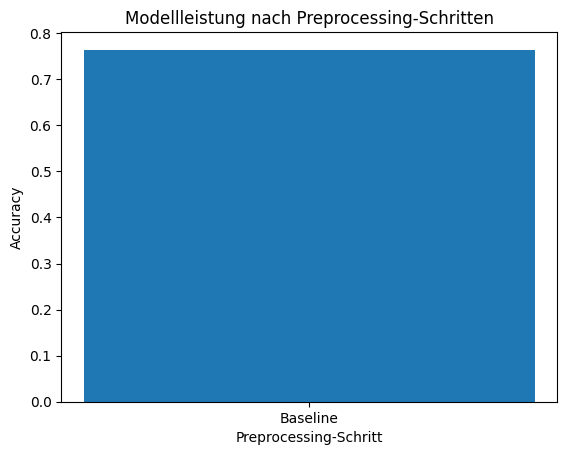

In [364]:
results = {
    'Baseline': accuracy_score(y_test, y_pred_baseline)
    #'Step 1': accuracy_score(y_test, y_pred_step1),
    # Füge weitere Schritte hinzu
}

# Balkendiagramm erstellen
plt.bar(results.keys(), results.values())
plt.xlabel('Preprocessing-Schritt')
plt.ylabel('Accuracy')
plt.title('Modellleistung nach Preprocessing-Schritten')
plt.show()

für das richtige modell muss ctry unknown funktion verändert werden, damit es Imputation gibt von town zu ctry siehe eda zelle 618

# Missing Values

## Data Quality

Der erste Preprocess Schritt ist das Erreichen der Datenqualität. Diese wird anhand folgender Funktionen erreicht:

In [365]:
def fix_unknownland(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt fehlende Länderwerte ('Ctry') basierend auf der Stadt ('Town').
    
    Falls 'Ctry' NaN ist, wird das Land anhand einer vordefinierten Zuordnung zur Stadt ermittelt.
    
    Args:
    df (pd.DataFrame): Eingabedaten mit den Spalten 'Ctry' (Land) und 'Town' (Stadt).
    
    Returns:
    pd.DataFrame: Daten mit aufgefüllten Länderinformationen.
    """
    town_to_country = {
        'Berlin': 'Germany',
        'London': 'UK',
        'Brisbane': 'Australia',
    }
    df['Ctry'] = df.apply(lambda row: town_to_country.get(row['Town'], row['Ctry']) if pd.isna(row['Ctry']) else row['Ctry'], axis=1)
    return df

def impute_town(df: pd.DataFrame) -> pd.DataFrame:
    """
    Füllt fehlende Städte ('Town') basierend auf dem bekannten Land ('Ctry') zufällig auf.
    
    Falls 'Town' NaN ist und 'Ctry' bekannt ist, wird eine Stadt aus einer vordefinierten Liste für das Land zufällig ausgewählt.
    
    Args:
    df (pd.DataFrame): Eingabedaten mit den Spalten 'Ctry' (Land) und 'Town' (Stadt).
    
    Returns:
    pd.DataFrame: Daten mit aufgefüllten Städten.
    """
    country_to_towns = {
        'Australia': ['Sydney', 'Melbourne', 'Brisbane'],
        'Germany': ['Berlin', 'Hamburg', 'Munich'],
        'UK': ['London', 'Birmingham', 'Manchester'],
        'USA': ['New York', 'Chicago', 'Los Angeles'],
        'India': ['Bangalore', 'Mumbai', 'Delhi'],
    }
    df['Town'] = df.apply(lambda row: np.random.choice(country_to_towns[row['Ctry']]) if pd.isna(row['Town']) and row['Ctry'] in country_to_towns else row['Town'], axis=1)
    return df

def calculate_biking_hours(df: pd.DataFrame) -> pd.DataFrame:
    """
    Berechnet fehlende Werte für 'Biking Hours per Week' basierend auf der Formel:
    Biking Hours per Week = Total Training Hours per Week - Swimming Hours per Week - Running Hours per Week.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalten 'Total Training Hours per Week', 
                           'Swimming Hours per Week', 'Running Hours per Week' und 'Biking Hours per Week' enthält.

    Returns:
        pd.DataFrame: Der DataFrame mit berechneten Werten für 'Biking Hours per Week'.
    """
    df['Biking Hours per Week'] = df.apply(
        lambda row: row['Total Training Hours per Week'] - row['Swimming Hours per Week'] - row['Running Hours per Week']
        if pd.isna(row['Biking Hours per Week']) and not pd.isna(row['Total Training Hours per Week'])
        else row['Biking Hours per Week'],
        axis=1
    )
    return df

def calculate_total_training_hours(df: pd.DataFrame) -> pd.DataFrame:
    """
    Berechnet die Werte für 'Total Training Hours per Week' basierend auf:
    Total Training Hours per Week = Swimming Hours per Week + Biking Hours per Week + Running Hours per Week.

    Diese Berechnung erfolgt für **alle** Einträge, unabhängig davon, ob bereits ein Wert existiert. Dadurch werden Ausreiser eliminiert.

    Args:
        df (pd.DataFrame): DataFrame mit den Spalten 'Swimming Hours per Week', 
                           'Biking Hours per Week', 'Running Hours per Week' und 
                           'Total Training Hours per Week'.

    Returns:
        pd.DataFrame: Der DataFrame mit neu berechneten Werten für 'Total Training Hours per Week'.
    """
    df = df.copy()  # Vermeidet Änderungen am Original-DataFrame
    df['Total Training Hours per Week'] = (
        df['Swimming Hours per Week'].fillna(0) + 
        df['Biking Hours per Week'].fillna(0) + 
        df['Running Hours per Week'].fillna(0)
    )
    return df


def handle_vo2_max(df: pd.DataFrame) -> pd.DataFrame:
    """
    Setzt unplausible Werte (z. B. negative Werte) in der Spalte 'VO2 Max' auf NaN.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalte 'VO2 Max' enthält.

    Returns:
        pd.DataFrame: Der DataFrame mit bereinigten Werten in 'VO2 Max'.
    """
    df['VO2 Max'] = df['VO2 Max'].apply(lambda x: x if 0 <= x <= 150 else np.nan)
    return df

def handle_age_of_customer(df: pd.DataFrame) -> pd.DataFrame:
    """
    Setzt unplausible Werte (z. B. negative Werte) in der Spalte 'Age of Customer' auf NaN.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalte 'Age of Customer' enthält.

    Returns:
        pd.DataFrame: Der DataFrame mit bereinigten Werten in 'Age of Customer'.
    """
    df['Age of customer'] = df['Age of customer'].apply(lambda x: x if x > 0 else np.nan)
    return df

def drop_color_of_watch(df: pd.DataFrame) -> pd.DataFrame:
    """
    Löscht die Spalte 'Color of Watch' aus dem DataFrame, da sie keinen Zusammenhang mit dem Label oder anderen Daten hat.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalte 'Color of Watch' enthält.

    Returns:
        pd.DataFrame: Der DataFrame ohne die Spalte 'Color of Watch'.
    """
    df = df.drop(columns=['Color of Watch'])
    return df

def drop_preferred_training_daytime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Löscht die Spalte 'Preferred Training Daytime' aus dem DataFrame, da sie keinen Zusammenhang mit dem Label oder anderen Daten hat.

    Args:
        df (pd.DataFrame): Der DataFrame, der die Spalte 'Preferred Training Daytime' enthält.

    Returns:
        pd.DataFrame: Der DataFrame ohne die Spalte 'Preferred Training Daytime'.
    """
    df = df.drop(columns=['Preferred Training Daytime'])
    return df

def impute_training_daytime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt fehlende Werte in 'Preferred Training Daytime' durch den häufigsten Wert (Modus).

    Args:
        df (pd.DataFrame): Der DataFrame mit der Spalte 'Preferred Training Daytime'.

    Returns:
        pd.DataFrame: DataFrame mit imputierten Werten.
    """
    df = df.copy()
    mode_value = df['Preferred Training Daytime'].mode()[0]  # Häufigster Wert
    df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
    return df

def custom_transform_dq(df: pd.DataFrame) -> pd.DataFrame:
    """
    Führt eine Reihe von Datenbereinigungs- und Vorverarbeitungsschritten durch.

    Args:
        df (pd.DataFrame): Der ursprüngliche DataFrame.
        custom_transform_ctry_town -> Erbung vorheriger Imputation und Baseline

    Returns:
        pd.DataFrame: Der bereinigte und vorverarbeitete DataFrame.
    """
    df = custom_transform_baseline(df)

    df = fix_unknownland(df)
    df = impute_town(df)
    df = calculate_biking_hours(df)
    df = calculate_total_training_hours(df)
    df = handle_vo2_max(df)
    #df = handle_age_of_customer(df)
    df = drop_color_of_watch(df)
    #df = drop_preferred_training_daytime(df)
    df = impute_training_daytime(df)  
    return df

Funktionen bereinigen inkonsistente oder ungültige Werte:


1. `fix_unknownland()` – Füllt fehlende Länder (`Ctry`) basierend auf der Stadt (`Town`) auf.
2. `impute_town()` – Setzt fehlende Städte (`Town`) zufällig basierend auf dem Land (`Ctry`).
3. `calculate_biking_hours()` – Berechnet fehlende `Biking Hours per Week` aus den anderen Sportstunden.
4. `calculate_total_training_hours()` – Setzt `Total Training Hours per Week` auf die Summe der Einzelsportarten.
5. `handle_vo2_max()` – Ersetzt unplausible `VO2 Max`-Werte (z. B. negativ) durch `NaN`.
6. `handle_age_of_customer()` – Setzt negative `Age of customer`-Werte auf `NaN`.
7. `drop_color_of_watch()` – Entfernt die Spalte `Color of Watch`.
8. `drop_preferred_training_daytime()` – Entfernt die Spalte `Preferred Training Daytime`.

In [366]:
pipeline_dq = create_pipeline(custom_transform_dq)

# Trainiere das Modell
pipeline_dq.fit(X_train, y_train)

y_pred_dq = pipeline_dq.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_dq))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dq))
print("Classification Report:\n", classification_report(y_test, y_pred_dq))

Accuracy: 0.7538461538461538
Confusion Matrix:
 [[91 19]
 [29 56]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       110
         1.0       0.75      0.66      0.70        85

    accuracy                           0.75       195
   macro avg       0.75      0.74      0.75       195
weighted avg       0.75      0.75      0.75       195



C:\Users\mario\AppData\Local\Temp\ipykernel_22300\3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also 

In [367]:
X_train_transformed = pipeline_dq[:-2].transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed)

C:\Users\mario\AppData\Local\Temp\ipykernel_22300\3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)


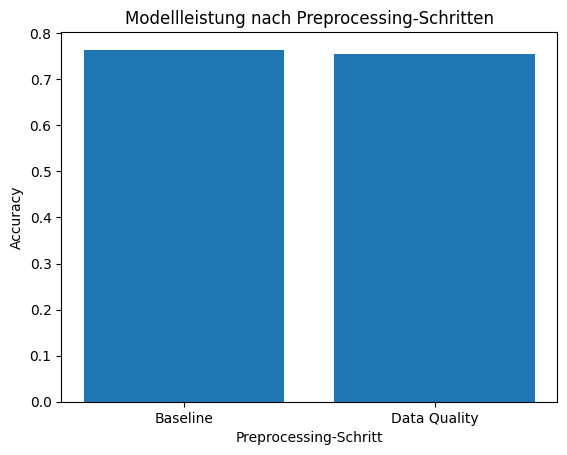

In [368]:
# Ergebnisse sammeln
results = {
    'Baseline': accuracy_score(y_test, y_pred_baseline),
    'Data Quality': accuracy_score(y_test, y_pred_dq)
    # Füge weitere Schritte hinzu
}

# Balkendiagramm erstellen
plt.bar(results.keys(), results.values())
plt.xlabel('Preprocessing-Schritt')
plt.ylabel('Accuracy')
plt.title('Modellleistung nach Preprocessing-Schritten')
plt.show()

Das neue Modell mit der Data Quality aus Eda, zeigt eine `Accuracy von 74,3 %`. Der `Recall (+1 %)`, die `Precision` bleiben stabil, und die `F1-Scores` hat sich minimal verschlechtert.

**Bis Dahin fertig**
**Trainingsdaten - Data Quality**
1. Löschen der 22 Zeilen, in denen das Label 0 ist.
2. Löschen der 7 Zeilen mit der doppelten ID.
3. Umbennung Germayn zu Germany in Spalte `Ctry` 
4. Anpassung UnknownLand in Spalte `Ctry`
5. Berechnung der fehlenden Werte für `Biking Hours per Week` durch `Total Training Hours per Week` - `Swimming Hours per Week` -  `Running Hours per Week` (Aureißer bei der Gesamttrainingszeit betreffen hier nicht die fehlenden Wert für Biking Hours) (*Rule based Imputation*)
6. Unplausible und fehlende Werte für `Total Training Hours per Week` durch andere Spalten berechnen lassen und ersetzen. (*Rule based Imputation*)
7. Setzen der unplausiblen Werte von `VO2 Max` und `Age of Customer` auf NaN.  
8. Löschung Feature `Color of Watch`, `Prefered Training Datetime` aufgrund fehlendem Zusammenhang mit Label und anderen Daten
Zu 8. `Prefered Training Datetime` erhöht die accuracy um zwei Prozente bereits im baseline Model

## Imputation

**Trainingsdaten - Imputation**  
1. 1 Fehlender Wert in `Days since Update` befüllen mit dem Mittelwert je Label, aufgrund fehlendem Zusammenhang mit anderen Daten
2. 1 Fehlender Wert in `Subscription Type` mit Hilfe Informationen `10k Running Time Prediction` befüllen (*Regression Imputation*)
3. 10 falsche Werte in `Age of Customer`  mit Hilfe folgender Spalten befüllen: `10k Running Time Prediction`, `Ctry`, `Support Cases of Customer`, `Customer Years` (*Regression Imputation*)
4. 19 Fehlende Werte in `Calories Burned per Week` mit Hilfe folgender Spalten befüllen: `Sex`, `Biking Hours per Week`, `Total Training Hours per Week`, `Swimming Hours per Week`, `Running Hours per Week` (Hauptsache Fahrradzeiten, andere Zeiten eher weniger relevant) (*Regression Imputation*)
5. 28 Fehlende Werte in `Goal of Training` mit Hilfe folgender Spalten befüllen: `Swimming Hours per Week`, `Biking Hours per Week`, `Running Hours per Week`, `Total Training Hours per Week`, `10k Running Time Prediction`, `Calories Burned per Week` (*Regression Imputation*)
6. 10 Fehlende Werte in `VO2 Max` mit Hilfe folgender Spalten befüllen: `Goal of Training`, `10k Running Time Prediction`, `Calories Burned per Week`, `Age of customer`
7. 27 Fehlende Werte in `Synchronisation` mit Hilfe folgender Spalten befüllen: `VO2 Max` (*Regression Imputation*) **habe ich nicht geschafft**
8. 39 Fehlende Werte in Town in einer Kombination aus *Regression Imputation* und *Rule based Imputation*: Erst einschränken, welche Auswahl an Städten möglich ist anhand von `Ctry`. Dann anhand folgender Werte bestimmen, welches aus den möglichen Städten die wahrscheinlichste ist: `Age of customer`, `Swimming Hours per Week`, `Biking Hours per Week`, `10k Running Time Prediction`, `Calories Burned per Week` 

In [369]:
def impute_subscription_type(df: pd.DataFrame) -> pd.DataFrame:
    """
    Füllt fehlende Werte in der Spalte 'Subscription Type' mithilfe einer Regression basierend auf '10k Running Time Prediction'.
    
    Args:
        df (pd.DataFrame): Der Eingabe-DataFrame mit den Spalten 'Subscription Type' (Kategorie) und 
                           '10k Running Time Prediction' (numerisch).

    Returns:
        pd.DataFrame: Der DataFrame mit imputierten Werten für 'Subscription Type'.
    """
    df_copy = df.copy()  # Kopie des DataFrames, um Originaldaten nicht zu verändern
    
    # Prüfen, ob überhaupt fehlende Werte in "Subscription Type" existieren
    if df_copy['Subscription Type'].isna().sum() == 0:
        return df_copy  # Falls keine fehlenden Werte, gib unveränderten DataFrame zurück
    
    # Label-Encoding für "Subscription Type"
    le = LabelEncoder()
    df_copy.dropna(subset=['Subscription Type'], inplace=True)  # Fehlende Werte vor Encoding entfernen
    df_copy['Subscription Type Encoded'] = le.fit_transform(df_copy['Subscription Type'])
    
    # Trainingsdaten (Zeilen ohne fehlende Werte)
    train_df = df_copy.dropna(subset=['Subscription Type Encoded'])

    # Regressionsmodell erstellen & trainieren
    reg = LinearRegression()
    reg.fit(train_df[['10k Running Time Prediction']], train_df['Subscription Type Encoded'])

    # Zeilen mit fehlendem "Subscription Type"
    missing_rows = df[df['Subscription Type'].isna()]

    if not missing_rows.empty:
        # Vorhersage für fehlende Werte
        predicted_values = reg.predict(missing_rows[['10k Running Time Prediction']])
        predicted_labels = le.inverse_transform([int(round(val)) for val in predicted_values])  # In Kategorie umwandeln

        # Fehlenden Wert im Original-DataFrame ersetzen
        df.loc[df['Subscription Type'].isna(), 'Subscription Type'] = predicted_labels

    return df  # DataFrame mit imputierten Werten zurückgeben


def impute_negative_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt Werte von -1 in 'Age of customer' mithilfe einer linearen Regression.

    Args:
        df (pd.DataFrame): Eingabe-DataFrame.

    Returns:
        pd.DataFrame: DataFrame mit imputierten Werten für 'Age of customer'.
    """
    df = df.copy()  # Kopie erstellen, um inplace-Änderungen zu vermeiden
    
    model = LinearRegression()

    # Feature-Spalten für das Modell
    feature_cols = ['10k Running Time Prediction', 'Support Cases of Customer', 'Customer Years']

    # Zeilen für Training auswählen (wo 'Age of customer' bekannt ist)
    train_data = df[df['Age of customer'].notna() & (df['Age of customer'] != -1)].copy()

    # Sicherstellen, dass Feature-Spalten keine fehlenden Werte enthalten
    train_data = train_data.dropna(subset=feature_cols)

    X_train = train_data[feature_cols]
    y_train = train_data['Age of customer']

    # Prüfen, ob genug Daten für das Training vorhanden sind
    if len(y_train) > 5:  # Mindestens 5 Datenpunkte für ein stabiles Modell
        model.fit(X_train, y_train)

        # Zeilen mit fehlendem oder ungültigem Alter (-1) auswählen
        missing_data_mask = df['Age of customer'] == -1

        # Prüfen, ob es Zeilen zum Imputieren gibt
        if missing_data_mask.any():
            X_test = df.loc[missing_data_mask, feature_cols].dropna()

            if not X_test.empty:  # Sicherstellen, dass X_test nicht leer ist
                df.loc[X_test.index, 'Age of customer'] = model.predict(X_test)

    # Falls nach der Imputation noch NaN-Werte vorhanden sind, ersetze sie mit dem Median
    df['Age of customer'] = df['Age of customer'].fillna(df['Age of customer'].median())

    return df

def impute_calories_burned(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt fehlende Werte in 'Calories Burned per Week' durch Regression Imputation.
    Nutzt: 'Sex', 'Biking Hours per Week', 'Total Training Hours per Week',
           'Swimming Hours per Week', 'Running Hours per Week'.

     Args:
        df (pd.DataFrame): Der Eingabe-DataFrame mit den Spalten 'Calories Burned per Week' .

    Returns:
        pd.DataFrame: Der DataFrame mit imputierten Werten für 'Calories Burned per Week'.
    """
    df = df.copy()  # Verhindert inplace-Änderungen

    # Label-Encoding für 'Sex', aber nur eine Kopie erstellen
    label_encoder = LabelEncoder()
    df['Sex Encoded'] = label_encoder.fit_transform(df['Sex'].astype(str))  # Sicherstellen, dass es Strings sind

    # Feature-Spalten für das Modell
    feature_cols = ['Sex Encoded', 'Biking Hours per Week', 'Total Training Hours per Week', 
                    'Swimming Hours per Week', 'Running Hours per Week']

    # Trainingsdaten: Nur Zeilen ohne NaN in "Calories Burned per Week" & ohne fehlende Feature-Werte
    train_data = df.dropna(subset=['Calories Burned per Week'] + feature_cols)

    X_train = train_data[feature_cols]
    y_train = train_data['Calories Burned per Week']

    # Lineares Modell trainieren
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Zeilen mit fehlenden "Calories Burned per Week" Werten
    missing_mask = df['Calories Burned per Week'].isna()
    
    if missing_mask.any():
        X_test = df.loc[missing_mask, feature_cols]

        # Entferne Zeilen mit fehlenden Werten, um den Fehler zu vermeiden
        X_test_clean = X_test.dropna()

        if not X_test_clean.empty:  # Falls nach dem Drop noch Zeilen übrig sind
            predicted_values = model.predict(X_test_clean)

            # Setze nur die vorhersagbaren Werte zurück
            df.loc[X_test_clean.index, 'Calories Burned per Week'] = predicted_values

    # Entferne die temporäre Spalte 'Sex Encoded'
    df = df.drop(columns=['Sex Encoded'])

    return df

def impute_goal_of_training(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ersetzt fehlende Werte in 'Goal of Training' mithilfe einer logistischen Regression (für kategoriale Werte).
    Nutzt als Prädiktoren:
    - 'Swimming Hours per Week'
    - 'Biking Hours per Week'
    - 'Running Hours per Week'
    - 'Total Training Hours per Week'
    - '10k Running Time Prediction'
    - 'Calories Burned per Week'
    
    
     Args:
        df (pd.DataFrame): Der Eingabe-DataFrame mit den Spalten ''Goal of Training' .

    Returns:
        pd.DataFrame: Der DataFrame mit imputierten Werten für ''Goal of Training'.
    """
    df = df.copy()  # Verhindert inplace-Änderungen

    # Label-Encoding für 'Goal of Training' (da kategoriale Variable)
    label_encoder = LabelEncoder()

    # Falls ALLE Werte in 'Goal of Training' fehlen -> Abbruch
    if df['Goal of Training'].isna().all():
        print("⚠ Alle Werte in 'Goal of Training' fehlen – Imputation nicht möglich.")
        return df

    df['Goal of Training Encoded'] = label_encoder.fit_transform(df['Goal of Training'].astype(str))

    # Features für die Regression
    feature_cols = ['Swimming Hours per Week', 'Biking Hours per Week', 'Running Hours per Week',
                    'Total Training Hours per Week', '10k Running Time Prediction', 'Calories Burned per Week']

    # Entferne Zeilen mit NaNs in Feature-Spalten (aber nicht in 'Goal of Training')
    df_clean = df.dropna(subset=feature_cols)

    # Trainingsdaten ohne NaN in 'Goal of Training'
    train_data = df_clean.dropna(subset=['Goal of Training'])

    X_train = train_data[feature_cols]
    y_train = train_data['Goal of Training Encoded']

    # Modell trainieren
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Zeilen mit fehlenden 'Goal of Training' Werten
    missing_mask = df['Goal of Training'].isna()

    if missing_mask.any():
        X_test = df.loc[missing_mask, feature_cols]

        # Entferne Zeilen mit NaN in den Prädiktor-Spalten (sonst Fehler in model.predict)
        X_test_clean = X_test.dropna()

        if not X_test_clean.empty:  # Falls noch Zeilen übrig sind
            predicted_values = model.predict(X_test_clean)

            # Rücktransformation der Werte in die ursprünglichen Kategorien
            df.loc[X_test_clean.index, 'Goal of Training'] = label_encoder.inverse_transform(predicted_values)

    # Entferne die temporäre Spalte
    df.drop(columns=['Goal of Training Encoded'], inplace=True)

    return df

def impute_vo2_max(df: pd.DataFrame) -> pd.DataFrame:
    """
    Füllt fehlende Werte in 'VO2 Max' mit Regression Imputation.
    
    Verwendet die Spalten:
    - 'Goal of Training' (kategorial, wird mit LabelEncoder kodiert)
    - '10k Running Time Prediction'
    - 'Calories Burned per Week'
    - 'Age of customer'
    
    Args:
        df (pd.DataFrame): Eingabedaten mit fehlenden Werten in 'VO2 Max'.
    
    Returns:
        pd.DataFrame: DataFrame mit imputierten Werten für 'VO2 Max'.
    """
    df = df.copy()  # Verhindert inplace-Änderungen

    # Kategoriale Variable "Goal of Training" in numerische Werte umwandeln
    le = LabelEncoder()
    if df['Goal of Training'].isna().sum() == 0:  # Prüfen, ob fehlende Werte in der Kategorie sind
        df['Goal of Training Encoded'] = le.fit_transform(df['Goal of Training'])
    else:
        df = df.dropna(subset=['Goal of Training'])  # Falls fehlend, Zeilen entfernen
        df['Goal of Training Encoded'] = le.fit_transform(df['Goal of Training'])

    # Regressions-Imputation mit IterativeImputer
    imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=42)
    features = ['Goal of Training Encoded', '10k Running Time Prediction', 'Calories Burned per Week', 'Age of customer']

    df['VO2 Max'] = imputer.fit_transform(df[['VO2 Max'] + features])[:, 0]  # Erste Spalte sind die imputierten Werte

    # Entferne die temporäre kodierte Spalte
    df.drop(columns=['Goal of Training Encoded'], inplace=True)

    return df

def impute_synchronisation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputiert fehlende Werte in der Spalte 'Synchronisation' basierend auf 'VO2 Max'
    mit einer logistischen Regression.

    Args:
        df (pd.DataFrame): Der Eingabe-DataFrame mit fehlenden Werten in 'Synchronisation'.

    Returns:
        pd.DataFrame: DataFrame mit imputierten Werten für 'Synchronisation'.
    """
    df = df.copy()  # Verhindert inplace-Änderungen

    # Falls "nan" als String gespeichert ist, konvertiere es zu einem echten NaN-Wert
    df['Synchronisation'] = df['Synchronisation'].replace('nan', np.nan)

    # Entferne Zeilen mit fehlendem 'VO2 Max', da es die Prädiktorvariable ist
    df = df.dropna(subset=['VO2 Max'])

    # Konvertiere 'Synchronisation' in eine binäre numerische Variable: 'Yes' → 1, 'No' → 0
    df['Synchronisation'] = df['Synchronisation'].replace({'Yes': 1, 'No': 0})

    # Trainingsdaten: Nur Zeilen, wo 'Synchronisation' bekannt ist
    train_data = df[df['Synchronisation'].notna()]

    # Testdaten: Zeilen, wo 'Synchronisation' fehlt (NaN)
    test_data = df[df['Synchronisation'].isna()]

    # Features und Labels für das Training
    X_train = train_data[['VO2 Max']]
    y_train = train_data['Synchronisation']

    # Prüfen, ob genug Daten zum Trainieren vorhanden sind
    if len(y_train) > 5:
        model = LogisticRegression()
        model.fit(X_train, y_train)  # Trainiere das Modell

        # Nur Vorhersagen für Zeilen mit fehlender Synchronisation
        if not test_data.empty:
            X_test = test_data[['VO2 Max']]
            y_pred = model.predict(X_test)

            # Setze vorhergesagte Werte zurück in den DataFrame
            df.loc[test_data.index, 'Synchronisation'] = y_pred

    # Konvertiere zurück in 'Yes' und 'No'
    df['Synchronisation'] = df['Synchronisation'].replace({1: 'Yes', 0: 'No'})

    return df


def all_imputation(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    
    #df = custom_transform_baseline(df)
    df = custom_transform_dq(df)

    df = impute_subscription_type(df)
    df = impute_negative_age(df)
    df = impute_calories_burned(df)
    df = impute_goal_of_training(df)
    df = impute_vo2_max(df)
    df = impute_synchronisation(df)
    return df

In [370]:
df_training[df_training["Age of customer"]==-1]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Color of Watch,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,,
C0212,-1.0,Male,USA,Chicago,2.78,1.16,2.94,6.89,52.24,40.09,3199.91,0.0,4.0,Recreation,Morning,Basic,Black,No,1.0,124.0
C0217,-1.0,Female,India,NaN,2.31,NaN,4.43,13.33,40.33,52.93,6736.52,0.0,6.0,Fitness,Evening,Free,Black,Yes,0.0,278.0
C0480,-1.0,Other,Australia,Melbourne,5.20,0.00,1.63,6.83,30.08,60.34,3151.63,2.0,5.0,Fitness,Morning,Premium,White,Yes,0.0,214.0
C0661,-1.0,Other,Germany,Hamburg,1.66,3.49,2.41,7.57,52.23,41.03,3796.06,4.0,1.0,Recreation,Morning,Free,Black,Yes,0.0,221.0
C0697,-1.0,Other,USA,New York,2.79,4.73,0.40,7.92,47.31,50.81,4045.48,1.0,2.0,Fitness,Evening,Premium,White,Yes,0.0,449.0
C0711,-1.0,Female,Germany,Berlin,3.09,4.62,3.29,10.99,48.52,43.20,5499.17,4.0,2.0,Fitness,Morning,Premium,Black,Yes,1.0,185.0
C0808,-1.0,Female,Germany,Berlin,1.74,1.49,0.88,4.11,39.28,48.41,1768.41,0.0,7.0,Recreation,NaN,Premium,Black,Yes,0.0,172.0
C0851,-1.0,Female,India,Mumbai,0.00,2.57,2.54,5.11,39.98,51.19,2831.74,1.0,5.0,Recreation,Morning,Free,Black,Yes,0.0,324.0
C0889,-1.0,Male,Australia,Brisbane,1.90,9.88,5.01,16.79,66.41,37.59,8561.68,1.0,3.0,Competition,Evening,Premium,White,Yes,1.0,378.0


In [371]:
pipeline_imp = create_pipeline(all_imputation)

# Trainiere das Modell
pipeline_imp.fit(X_train, y_train)

y_pred_imp = pipeline_imp.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_imp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_imp))
print("Classification Report:\n", classification_report(y_test, y_pred_imp))

C:\Users\mario\AppData\Local\Temp\ipykernel_22300\3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also 

Accuracy: 0.7538461538461538
Confusion Matrix:
 [[92 18]
 [30 55]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       110
         1.0       0.75      0.65      0.70        85

    accuracy                           0.75       195
   macro avg       0.75      0.74      0.74       195
weighted avg       0.75      0.75      0.75       195



c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Local\Temp\ipykernel_22300\3928837657.py:265: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Synchronisation'] = df['Synchronisation'].replace({'Yes': 1, 'No': 0})


1. `impute_subscription_type()` – Füllt fehlende Werte in der Spalte `Subscription Type` mithilfe einer Regression basierend auf `10k Running Time Prediction`.
2. `impute_negative_age()` – Ersetzt -1-Werte in der `Age of Customer`-Spalte durch eine lineare Regression, die auf anderen numerischen Features basiert.
3. `impute_calories_burned()` – Ersetzt fehlende Werte in der Spalte `Calories Burned per Week` durch Regression unter Verwendung mehrerer Trainingsmerkmale.
4. `impute_goal_of_training()` – Imputiert fehlende Werte in der Spalte `Goal of Training` mit einer logistischen Regression, die auf verschiedenen Trainingsdaten basiert.
5. `impute_vo2_max()` – Füllt fehlende Werte in der `VO2 Max`-Spalte durch Regression, unter Verwendung von Features wie `Goal of Training`, `10k Running Time Prediction`, `Calories Burned per Week` und `Age of Customer`.
6. `impute_synchronisation()` - Ersetzt nan String Werte, mit neuen Werte durch `VO2 Max` Imputation 

Das Modell hat eine `Accuracy` von `74.8%`, was darauf hinweist, dass es in der Lage ist, viele der Beispiele korrekt zu klassifizieren. Der Recall für Klasse 0 (negativ) ist relativ hoch (84%), was darauf hinweist, dass das Modell in den meisten Fällen korrekt vorhersagt, wenn ein Beispiel tatsächlich negativ ist. Jedoch ist der Recall für Klasse 1 (positiv) mit 66% etwas niedriger, was darauf hindeutet, dass das Modell Schwierigkeiten hat, alle positiven Beispiele zu erkennen.

Trotzdem ist der F1-Score für beide Klassen relativ gut, insbesondere für Klasse 0 mit einem F1-Score von 0.79. Insgesamt zeigt das Modell eine starke Leistung in Bezug auf die Negativklassifikation, hat jedoch etwas mehr Schwierigkeiten, alle positiven Fälle zu erfassen.


Man erkennt aber keine erheblichen Verbesserung durch das Missing Values Process.

In [372]:
df_training_no_missing_values = all_imputation(df_training)
df_training_no_missing_values

C:\Users\mario\AppData\Local\Temp\ipykernel_22300\3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also 

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,
C0001,61.0,Other,UK,Birmingham,2.52,0.10,1.78,4.40,23.08,60.72,2329.950000,2.0,1.0,Fitness,Evening,Free,Yes,1.0,205.0
C0003,57.0,Other,Australia,Sydney,1.55,10.01,4.57,16.13,39.04,54.37,7904.930000,2.0,1.0,Fitness,Evening,Premium,Yes,0.0,277.0
C0004,30.0,Other,India,Bangalore,1.19,12.04,8.64,21.87,71.59,33.92,10839.810000,2.0,0.0,Competition,Afternoon,Free,Yes,1.0,180.0
C0005,21.0,Male,Germany,Munich,2.25,4.67,0.92,7.84,49.09,44.97,3958.160897,3.0,0.0,Recreation,Evening,Premium,No,1.0,185.0
C0006,63.0,Male,India,Mumbai,0.80,5.88,0.67,7.35,13.91,62.46,3575.960000,3.0,3.0,Recreation,Morning,Basic,Yes,0.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0996,28.0,Female,Australia,Brisbane,2.38,0.28,2.79,5.45,61.05,40.38,2589.770000,0.0,3.0,Recreation,Morning,Premium,Yes,0.0,400.0
C0997,54.0,Female,Australia,Melbourne,1.80,4.45,1.35,7.60,34.50,56.38,4104.150000,0.0,3.0,Recreation,Afternoon,Free,Yes,0.0,95.0
C0998,35.0,Other,USA,New York,3.91,0.57,5.57,10.05,58.63,37.27,5078.450000,4.0,6.0,Fitness,Afternoon,Premium,Yes,1.0,169.0


In [373]:
df_training_no_missing_values.isnull().sum()

Age of customer                  0
Sex                              0
Ctry                             0
Town                             0
Swimming Hours per Week          0
Biking Hours per Week            0
Running Hours per Week           0
Total Training Hours per Week    0
VO2 Max                          0
10k Running Time Prediction      0
Calories Burned per Week         0
Support Cases of Customer        0
Customer Years                   0
Goal of Training                 0
Preferred Training Daytime       0
Subscription Type                0
Synchronisation                  0
User of latest model             0
Days since Update                0
dtype: int64

In [374]:
df_training_no_missing_values["Synchronisation"].unique()

array(['Yes', 'No'], dtype=object)

In [375]:
df_training_no_missing_values[df_training_no_missing_values["Age of customer"].isnull()]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,


In [376]:
df_training_no_missing_values[df_training_no_missing_values["VO2 Max"]>200]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,


In [377]:
df_training_no_missing_values[df_training_no_missing_values["Total Training Hours per Week"]>90]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,


Ich habe die Daten verbessert. Die Ausreißer sind draußen und wurden imputiert.

In [378]:
# Nachtrag: In einer Zeile der Spalte "Subscription Type" stand "nan" (ein String). Dieser wird nun mit "Free" ersetzt, da free der häufigste Wert dieser Spalte ist.
# Ersetze den Stringwert "nan" in der Spalte "Subscription Type" mit dem String "Free"
df_training_no_missing_values['Subscription Type'] = df_training_no_missing_values['Subscription Type'].replace('nan', 'Free')

In [379]:
df_training_no_missing_values.to_parquet("../data/processed/df_training_no_missing_values.parquet", index=True)

# Outlier

In [380]:
def remove_outliers(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Entfernt Ausreißer aus den angegebenen Spalten des DataFrames.
    
    Args:
    df (pd.DataFrame): Eingabedaten.
    columns (list): Liste der Spalten, in denen Ausreißer entfernt werden sollen.
    
    Return:
    pd.DataFrame: DataFrame ohne Ausreißer in den angegebenen Spalten.
    """
    df_no_outliers = X.copy()
    for column in columns:
        Q1 = df_no_outliers[column].quantile(0.25)
        Q3 = df_no_outliers[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]
    
    # Stelle sicher, dass die Zeilen aus X und y übereinstimmen
    y_no_outliers = y[df_no_outliers.index]
    
    return df_no_outliers, y_no_outliers

columns_to_check = ['Age of customer', 'Swimming Hours per Week', 'Biking Hours per Week', 'Running Hours per Week', 
                    'Total Training Hours per Week', 'VO2 Max', '10k Running Time Prediction', 'Calories Burned per Week', 'Support Cases of Customer',
                    "Customer Years"]


In [381]:
df_training_no_missing_values

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,
C0001,61.0,Other,UK,Birmingham,2.52,0.10,1.78,4.40,23.08,60.72,2329.950000,2.0,1.0,Fitness,Evening,Free,Yes,1.0,205.0
C0003,57.0,Other,Australia,Sydney,1.55,10.01,4.57,16.13,39.04,54.37,7904.930000,2.0,1.0,Fitness,Evening,Premium,Yes,0.0,277.0
C0004,30.0,Other,India,Bangalore,1.19,12.04,8.64,21.87,71.59,33.92,10839.810000,2.0,0.0,Competition,Afternoon,Free,Yes,1.0,180.0
C0005,21.0,Male,Germany,Munich,2.25,4.67,0.92,7.84,49.09,44.97,3958.160897,3.0,0.0,Recreation,Evening,Premium,No,1.0,185.0
C0006,63.0,Male,India,Mumbai,0.80,5.88,0.67,7.35,13.91,62.46,3575.960000,3.0,3.0,Recreation,Morning,Basic,Yes,0.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0996,28.0,Female,Australia,Brisbane,2.38,0.28,2.79,5.45,61.05,40.38,2589.770000,0.0,3.0,Recreation,Morning,Premium,Yes,0.0,400.0
C0997,54.0,Female,Australia,Melbourne,1.80,4.45,1.35,7.60,34.50,56.38,4104.150000,0.0,3.0,Recreation,Afternoon,Free,Yes,0.0,95.0
C0998,35.0,Other,USA,New York,3.91,0.57,5.57,10.05,58.63,37.27,5078.450000,4.0,6.0,Fitness,Afternoon,Premium,Yes,1.0,169.0


# Testdaten

In [382]:
df_test.head()

,ID,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,...,Calories Burned per Week,Support Cases of Customer,Customer Years,Most current software update,Goal of Training,Preferred Training Daytime,Subscription Type,Color of Watch,Synchronisation,User of latest model
0,C0001,60.0,Other,Germany,Hamburg,1.80,4.44,0.34,6.58,23.02,...,3062.83,3,4,2023-12-05,Recreation,Evening,Premium,Black,No,0
1,C0002,53.0,Male,Germayn,Berlin,1.77,5.42,5.60,12.79,52.46,...,6651.29,2,4,2024-04-23,Recreation,Evening,Free,White,Yes,0
2,C0003,30.0,Other,UK,London,4.05,6.98,4.03,15.07,73.21,...,7506.12,0,6,2024-12-30,Competition,Morning,Free,Black,Yes,1
3,C0004,24.0,Other,Germany,Hamburg,3.22,10.54,4.23,17.99,74.64,...,9134.26,3,6,2023-10-30,Competition,Morning,Premium,White,No,1
4,C0005,53.0,Male,USA,Los Angeles,3.15,3.03,5.40,11.58,51.22,...,5709.64,3,8,2024-12-23,Fitness,Afternoon,Free,Black,Yes,0


In [383]:
df_test.dropna(subset=['User of latest model'], inplace=True)
df_test.drop_duplicates(subset='ID', inplace=True)
df_test.set_index("ID", inplace=True)

In [384]:
df_test['Most current software update'] = pd.to_datetime(df_test['Most current software update'])
df_test['Days since Update'] = (pd.Timestamp.today() - df_test['Most current software update']).dt.days
df_test.drop(columns=['Most current software update'], inplace=True)

def fill_days_since_update(df):
    """
    Füllt fehlende Werte in 'Days since Update' mit dem Mittelwert je Label.
    """
    df['Days since Update'] = df.groupby('User of latest model')['Days since Update'].transform(lambda x: x.fillna(x.mean()))
    return df
df_test = fill_days_since_update(df_test)


In [385]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, C0001 to C0500
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age of customer                479 non-null    float64
 1   Sex                            480 non-null    object 
 2   Ctry                           480 non-null    object 
 3   Town                           480 non-null    object 
 4   Swimming Hours per Week        480 non-null    float64
 5   Biking Hours per Week          470 non-null    float64
 6   Running Hours per Week         480 non-null    float64
 7   Total Training Hours per Week  480 non-null    float64
 8   VO2 Max                        465 non-null    float64
 9   10k Running Time Prediction    480 non-null    float64
 10  Calories Burned per Week       480 non-null    float64
 11  Support Cases of Customer      480 non-null    int64  
 12  Customer Years                 480 non-null    in

In [386]:
df_test_no_missing_values = all_imputation(df_test)
df_test_no_missing_values

C:\Users\mario\AppData\Local\Temp\ipykernel_22300\3135932731.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Preferred Training Daytime'].fillna(mode_value, inplace=True)
c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also 

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,
C0001,60.0,Other,Germany,Hamburg,1.80,4.44,0.34,6.58,23.020000,59.52,3062.83,3,4,Recreation,Evening,Premium,No,0,435
C0002,53.0,Male,Germany,Berlin,1.77,5.42,5.60,12.79,52.460000,50.26,6651.29,2,4,Recreation,Evening,Free,Yes,0,295
C0003,30.0,Other,UK,London,4.05,6.98,4.03,15.06,73.210000,35.87,7506.12,0,6,Competition,Morning,Free,Yes,1,44
C0004,24.0,Other,Germany,Hamburg,3.22,10.54,4.23,17.99,74.640000,36.51,9134.26,3,6,Competition,Morning,Premium,No,1,471
C0005,53.0,Male,USA,Los Angeles,3.15,3.03,5.40,11.58,51.220000,48.41,5709.64,3,8,Fitness,Afternoon,Free,Yes,0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0495,43.0,Female,UK,Birmingham,4.55,0.86,5.19,10.60,59.160000,39.37,5579.17,2,3,Fitness,Afternoon,Premium,No,1,248
C0496,60.0,Female,USA,Chicago,1.18,10.67,7.19,19.04,44.230000,49.77,9713.87,4,5,Competition,Morning,Basic,Yes,0,207
C0498,44.0,Male,India,Delhi,1.07,3.80,2.87,7.74,55.210000,44.59,3679.10,2,1,Fitness,Morning,Free,Yes,0,314


In [387]:
df_test_no_missing_values["Synchronisation"].unique()

array(['No', 'Yes'], dtype=object)

In [388]:
df_test_no_missing_values[df_test_no_missing_values["Age of customer"].isnull()]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,


In [389]:
df_test_no_missing_values[df_test_no_missing_values["Total Training Hours per Week"]>90]

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update
ID,,,,,,,,,,,,,,,,,,,
C0186,44.0,Male,USA,New York,0.46,97.63,1.91,100.0,55.67,47.37,100.0,0,6,Recreation,Afternoon,Basic,Yes,1,422


In [390]:
df_test_no_missing_values.to_parquet("../data/processed/df_test_no_missing_values.parquet", index=True)

<h1> Marios Teil---------------------------------------- </h1>

In [391]:
# DFs einlesen
df_training_no_missing_values = pd.read_parquet(
    "../data/processed/df_training_no_missing_values.parquet"
)
df_test_no_missing_values = pd.read_parquet(
    "../data/processed/df_test_no_missing_values.parquet"
)

<h1> Benchmarking anlegen </h4>
Um die Processingschritte besser evaluieren zu können führe ich nach jedem Processing Schritt ein Benchmarking (Modellfit) aus und speichere die Ergebnisse im benchmark_df. Das benchmark_df wird am Ende für die Visualisierung des Processingnutzens benutzt. Das Benchmarking vergleicht jeweils den Processingschritt im Verhältnis zur Baseline.

Ich benchmarke nicht nur die logistische Regression (LR), sondern auch ein SVM-Modell, da LR gut mit nicht-skalierten und nicht-normalisierten Daten umgehen kann und daher wahrscheinlich keine Modellverbesserung durch die folgenden Verarbeitungsschritte entstehen. (Beim SVM-Modell sollten aber beil gewiisen Verarbeitungsschritten Verbesserungen zu sehen sein).

Funktion für das Benchmarking der Logistischen Regression:

In [392]:
# DataFrame zum Speichern der Ergebnisse
benchmark_df = pd.DataFrame(
    columns=["Run", "Accuracy", "Precision", "Recall", "F1-Score"]
)

def run_benchmark_lr(numeric_features, categorical_features, run):
    """
    Führt das Benchmarking eines Modells (z.B. Logistic Regression) durch.

    Parameter:
        numeric_features (list): Liste der Spaltennamen für numerische Features.
        categorical_features (list): Liste der Spaltennamen für kategoriale Features.
        run (str): Bezeichnung des Laufs (Run-Name).

    Erwartet:
        - df_training_no_missing_values: DataFrame, der die bereinigten Daten enthält.
        - benchmark_df: DataFrame, in den die Ergebnisse eingefügt werden.
        - custom_transform_baseline: Transformation, die in der Pipeline verwendet wird.
        - create_pipeline: Funktion, die eine Pipeline erzeugt.
    """

    # Auswahl der relevanten Spalten (numerische und kategoriale Features sowie das Ziel)
    df_training = df_training_no_missing_values[
        numeric_features + categorical_features + ["User of latest model"]
    ].copy()

    # Aufteilen in Features (X) und Zielvariable (y)
    X = df_training.drop("User of latest model", axis=1)
    y = df_training["User of latest model"]

    # Train-Test-Split (80% Training, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Erstellen der Pipeline unter Verwendung des custom_transform_baseline und der numerischen Features
    pipeline_baseline = create_pipeline(
        custom_transform_baseline, numeric_features=numeric_features
    )

    # Trainieren des Modells
    pipeline_baseline.fit(X_train, y_train)

    # Vorhersagen auf dem Testdatensatz
    y_pred_baseline = pipeline_baseline.predict(X_test)

    # Berechnen der Metriken
    accuracy = accuracy_score(y_test, y_pred_baseline)
    class_report = classification_report(y_test, y_pred_baseline, output_dict=True)
    precision = class_report["weighted avg"]["precision"]
    recall = class_report["weighted avg"]["recall"]
    f1_score_value = class_report["weighted avg"]["f1-score"]

    # Ergebnisse in einem DataFrame zusammenfassen
    new_row = pd.DataFrame(
        [
            {
                "Run": run,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1_score_value,
            }
        ]
    )

    # Hinzufügen der neuen Zeile zum globalen benchmark_df
    global benchmark_df
    benchmark_df = pd.concat([benchmark_df, new_row], ignore_index=True)

    # Optional: Rückgabe des aktualisierten benchmark_df
    return benchmark_df

Funktion für das Benschmarking des SVM-Modells

In [393]:
def run_svm_benchmark(df, features, target, run_svm):
    """
    Führt ein SVM-Training mit den angegebenen Features durch und speichert die Ergebnisse.
    
    :param df: DataFrame mit Trainingsdaten
    :param features: Liste der zu verwendenden Features
    :param target: Zielvariable
    :param run_svm: Name des SVM-Laufs
    :param benchmark_df: DataFrame zur Speicherung der Ergebnisse
    :return: Aktualisiertes benchmark_df mit den neuen Metriken
    """
    X = df[features]
    y = df[target]
    
    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # SVM-Modell trainieren
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_model.fit(X_train, y_train)
    
    # Vorhersagen treffen
    y_pred = svm_model.predict(X_test)
    
    # Metriken berechnen
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = {
        'Run': run_svm,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }
    
    # Ergebnisse speichern
    global benchmark_df
    benchmark_df = pd.concat([benchmark_df, pd.DataFrame([metrics])], ignore_index=True).reset_index(drop=True)
    
    return benchmark_df

Baseline Benchmarking durchführen:

In [394]:
run_benchmark_lr(
    categorical_features=[
        "Sex",
        "Ctry",
        "Town",
        "Support Cases of Customer",
        "Goal of Training",
        "Preferred Training Daytime",
        "Subscription Type",
        "Synchronisation",
    ],
    numeric_features=[
        "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Customer Years",
        "Days since Update",
    ],
    run="LR Baseline",
)

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Local\Temp\ipykernel_22300\3780117238.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_df = pd.concat([benchmark_df, new_row], ignore_index=True)


,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642


In [395]:
run_svm_benchmark(
    df_training_no_missing_values,
    features=[
        "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Customer Years",
        "Days since Update",
    ],
    target="User of latest model",
    run_svm="SVM Baseline",
)

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332


Nun weiß ich, wie gut meine Modelle mit den mir zur Verfügung gestellten Daten (df_training_no_missing_values) sind. Im folgenden werde ich df_training_no_missing_values und df_test_no_missing_values weiter verarbeiten.

<h1> Neue Features berechnen (Feature Engineering):</h1>
Im  folgenden werden 2 neue Features berechnet, die dem Modell helfen könnten, besser zu klassifizieren.

<h2> Training Efficiency </h2>
Die Traingseffizent könnte Einfluss darauf haben, ob jemand das neuse Modell hat, da Leute die viel Wert auf Sport legen eher effizent trainieren und eher viel Geld für den Sport ausgeben.

In [396]:
df_training_no_missing_values["Training Efficiency"] = (
    df_training_no_missing_values["Calories Burned per Week"]
    / df_training_no_missing_values["Total Training Hours per Week"]
)
df_test_no_missing_values["Training Efficiency"] = (
    df_test_no_missing_values["Calories Burned per Week"]
    / df_test_no_missing_values["Total Training Hours per Week"]
)

<h2> Support-Fälle pro Jahr </h2>
Die Anzahl der Supportfälle pro Jahr könnte Einfluss darauf haben, ob der user das neuste modell hat, da häufige Supportfälle auf häufigen technischen Störungen und eine damit verbundene Kundenunzufriedenheit schließen lässt und unzufriedene Kunden wahrscheinlich nicht ein neuere Modell nachkaufen, sondern die Marke wechseln. 

In [397]:
# Berechnung der Support_per_Year, wobei Division durch 0 behandelt wird
df_training_no_missing_values['Support_per_Year'] = (
    df_training_no_missing_values['Support Cases of Customer'] /
    df_training_no_missing_values['Customer Years']
)
df_test_no_missing_values['Support_per_Year'] = (
    df_test_no_missing_values['Support Cases of Customer'] /
    df_test_no_missing_values['Customer Years']
)

# Ersetze NaN-Werte
df_training_no_missing_values['Support_per_Year'] = df_training_no_missing_values['Support_per_Year'].fillna(0)
df_test_no_missing_values['Support_per_Year'] = df_test_no_missing_values['Support_per_Year'].fillna(0)

# Mapping auf 5 Kategorien
bins = [0, 1, 2, 3, 4, float('inf')]
labels = [0, 1, 2, 3, 4]

df_training_no_missing_values['Support_per_Year'] = pd.cut(
    df_training_no_missing_values['Support_per_Year'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)
df_test_no_missing_values['Support_per_Year'] = pd.cut(
    df_test_no_missing_values['Support_per_Year'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Optional: Weitere Behandlung von 'NaN' nach der Kategorisierung, falls notwendig
df_training_no_missing_values['Support_per_Year'] = df_training_no_missing_values['Support_per_Year'].fillna(0)
df_test_no_missing_values['Support_per_Year'] = df_test_no_missing_values['Support_per_Year'].fillna(0)

Benchmarkings durchführen:

In [398]:
run_benchmark_lr(
    categorical_features=[
        "Sex",
        "Ctry",
        "Town",
        "Support Cases of Customer",
        "Goal of Training",
        "Preferred Training Daytime",
        "Subscription Type",
        "Synchronisation",
        "Support_per_Year",
    ],
    numeric_features=[
        "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Customer Years",
        "Days since Update",
        "Training Efficiency",
    ],
    run="LR Feature Engineering",
)

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797


In [399]:
run_svm_benchmark(df_training_no_missing_values,features = ["Age of customer", "Swimming Hours per Week", "Biking Hours per Week", "Running Hours per Week", 
    "Total Training Hours per Week", "VO2 Max", "10k Running Time Prediction", "Calories Burned per Week", 
    "Customer Years", "Days since Update", "Support_per_Year", "Training Efficiency"], target= 'User of latest model', run_svm='SVM Feature Engineering')

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455


<h1> Numerische Features transformieren

<h2> Transformation numerischer Features hin zur Normalverteilung: </h2>
Im folgenden wird für jedes numerische Feature der Algorithmus gesucht, der die Daten am besten einer Normalverteilung anpasst. Dann wird der entsprechende Algorithmus genutzt, um die Daten zu transformieren und in eine neue Spalte "Alter_name + Normalver." gespeichert.

Die getesten Algorithmen sind Quantile Transformation und Power Transformations (Box-Cox und Yeo-Johnson)

Hier die Funktion dafür:

In [400]:
def evaluate_normalization(df, column):
    """
    Applies normalization transformations to a DataFrame column, 
    generates QQ-plots for each transformation, and identifies the best algorithm.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    column (str): Name of the column to be transformed and analyzed.
    """
    # Extract and drop missing values
    original_series = df[column].dropna()
    if original_series.empty:
        print("No data available after dropping missing values.")
        return
    original_data = original_series.values
    
    # Dictionary to store transformed data
    trans_data = {
        'Original': original_data,
        'QuantileTransformer': None,
        'Box-Cox': None,
        'Yeo-Johnson': None
    }
    
    # Apply transformations
    try:
        # Quantile Transformer
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(original_data)))
        trans_data['QuantileTransformer'] = qt.fit_transform(original_data.reshape(-1, 1)).flatten()
    except Exception as e:
        print(f"QuantileTransformer error: {str(e)}")
    
    try:
        # Box-Cox Transformer (nur für positive Werte)
        if np.all(original_data > 0):
            pt = PowerTransformer(method='box-cox')
            trans_data['Box-Cox'] = pt.fit_transform(original_data.reshape(-1, 1)).flatten()
        else:
            print("Box-Cox nicht möglich (enthält nicht-positive Werte).")
    except Exception as e:
        print(f"Box-Cox error: {str(e)}")
    
    try:
        # Yeo-Johnson Transformation (auch für negative Werte geeignet)
        pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
        trans_data['Yeo-Johnson'] = pt_yeo_johnson.fit_transform(original_data.reshape(-1, 1)).flatten()
    except Exception as e:
        print(f"Yeo-Johnson error: {str(e)}")
    
    # Create plots and calculate metrics
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # Eine Zeile mit vier Spalten
    plt.subplots_adjust(wspace=0.3)
    metrics = {}
    
    for idx, (name, data) in enumerate(trans_data.items()):
        ax = axes[idx]
        
        if data is None or len(data) == 0:
            ax.text(0.5, 0.5, 'Transformation failed', ha='center')
            ax.set_title(name)
            continue
            
        # Generate QQ-plot
        (osm, osr), (slope, intercept, r) = stats.probplot(data, dist='norm')
        r_squared = r**2
        ax.scatter(osm, osr, alpha=0.5, label='Data')
        ax.plot(osm, slope*osm + intercept, 'r-', label='Normal line')
        ax.set_title(f'{name} (R² = {r_squared:.3f})')
        ax.legend()
        
        # Store metrics (exclude Original)
        if name != 'Original':
            metrics[name] = r_squared
    
    plt.show()
    
    # Find and print best transformation
    if not metrics:
        print("No valid transformations to evaluate.")
        return
    
    best_name = max(metrics, key=metrics.get)
    
    # Check if the R² of original data is as good as the best transformation
    original_r_squared = stats.probplot(original_data, dist='norm')[1][2]**2
    if original_r_squared >= metrics[best_name]:
        print("No algorithm improved the data distribution.")
    else:
        print(f"Best normalization algorithm: {best_name} (R² = {metrics[best_name]:.3f})")


Und hier die iterative Suche nach dem betsen Transformationsalgorithmus für die numerischen Features:

<h3> Training Efficiency

Box-Cox nicht möglich (enthält nicht-positive Werte).


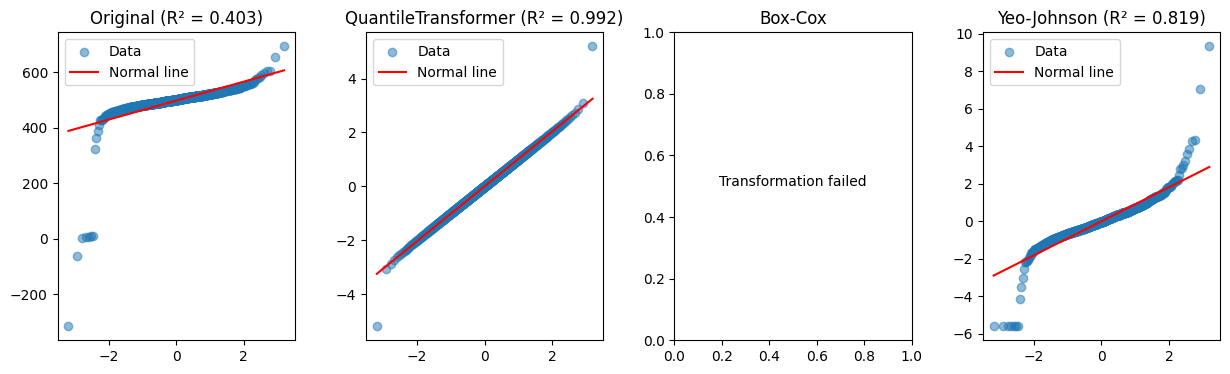

Best normalization algorithm: QuantileTransformer (R² = 0.992)


In [401]:
evaluate_normalization(df_training_no_missing_values, 'Training Efficiency')

Quantile Transformer sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [402]:
# Quantile Transformation für "VO2 Max"
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=400)
df_training_no_missing_values['Training Efficiency Normalver.'] = quantile_transformer.fit_transform(df_training_no_missing_values[['Training Efficiency']])
df_test_no_missing_values['Training Efficiency Normalver.'] = quantile_transformer.fit_transform(df_test_no_missing_values[['Training Efficiency']])

<h3> Age of Customer

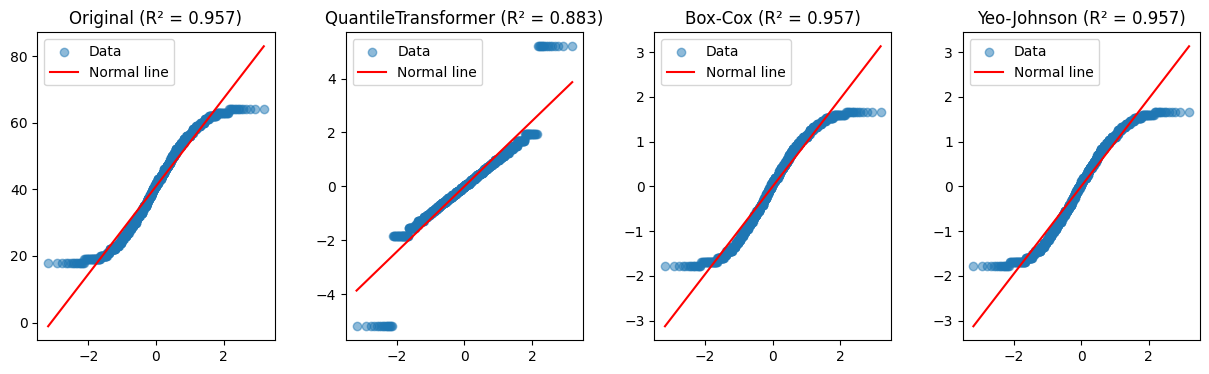

No algorithm improved the data distribution.


In [403]:
evaluate_normalization(df_training_no_missing_values, 'Age of customer')

Age of customer eignet sich nicht für eine Normalisierung (bester Algorithmus ist nicht besser als Originaldaten), daher wird es nicht transformiert.

<h3> Swimming Hours per Week

Box-Cox nicht möglich (enthält nicht-positive Werte).


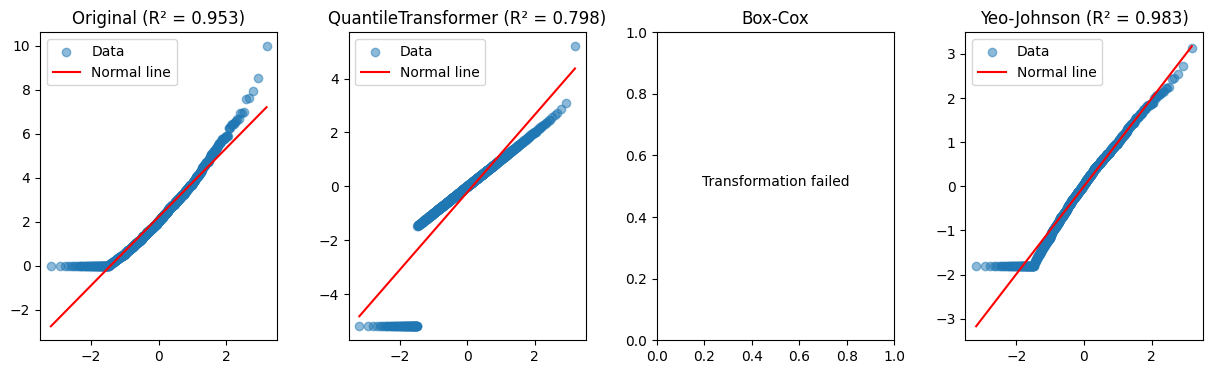

Best normalization algorithm: Yeo-Johnson (R² = 0.983)


In [404]:
evaluate_normalization(df_training_no_missing_values, 'Swimming Hours per Week')

Yeo-Johnson sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [405]:
# Yeo-Johnson Transformation für "Swimming Hours per Week"
pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
df_training_no_missing_values['Swimming Hours per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_training_no_missing_values[['Swimming Hours per Week']])
df_test_no_missing_values['Swimming Hours per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_test_no_missing_values[['Swimming Hours per Week']])

<h3> Biking Hours per Week

Box-Cox nicht möglich (enthält nicht-positive Werte).


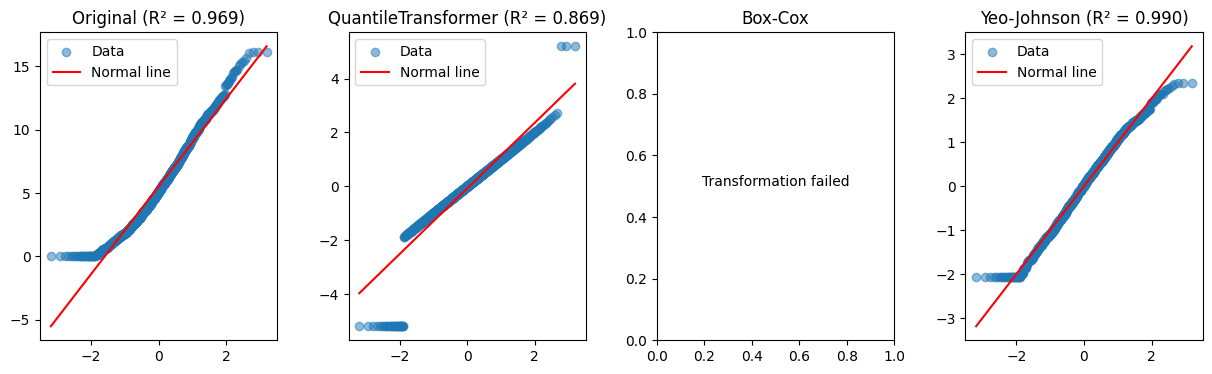

Best normalization algorithm: Yeo-Johnson (R² = 0.990)


In [406]:
evaluate_normalization(df_training_no_missing_values, 'Biking Hours per Week')

Yeo-Johnson sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [407]:
# Yeo-Johnson Transformation für "Biking Hours per Week"
pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
df_training_no_missing_values['Biking Hours per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_training_no_missing_values[['Biking Hours per Week']])
df_test_no_missing_values['Biking Hours per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_test_no_missing_values[['Biking Hours per Week']])

<h3> Running Hours per Week

Box-Cox nicht möglich (enthält nicht-positive Werte).


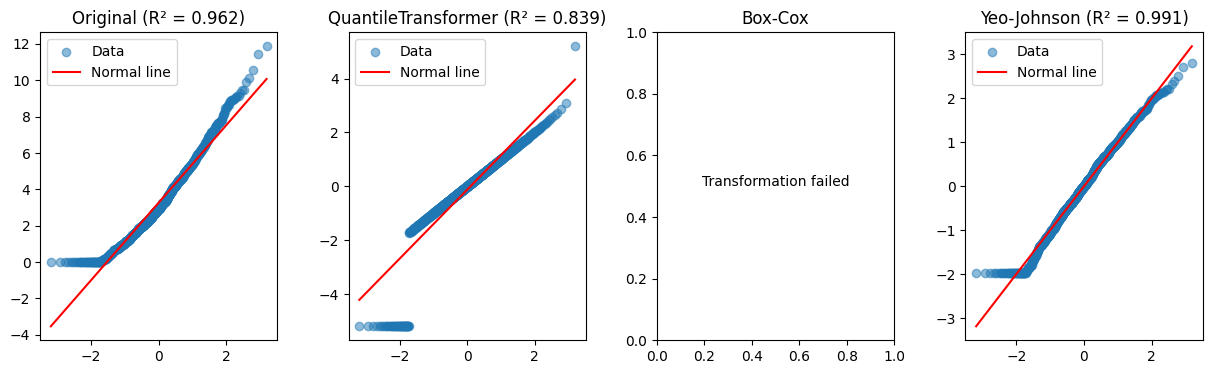

Best normalization algorithm: Yeo-Johnson (R² = 0.991)


In [408]:
evaluate_normalization(df_training_no_missing_values, 'Running Hours per Week')

Yeo-Johnson sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [409]:
# Yeo-Johnson Transformation für "Running Hours per Week"
pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
df_training_no_missing_values['Running Hours per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_training_no_missing_values[['Running Hours per Week']])
df_test_no_missing_values['Running Hours per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_test_no_missing_values[['Running Hours per Week']])

<h3> Total Training Hours per Week

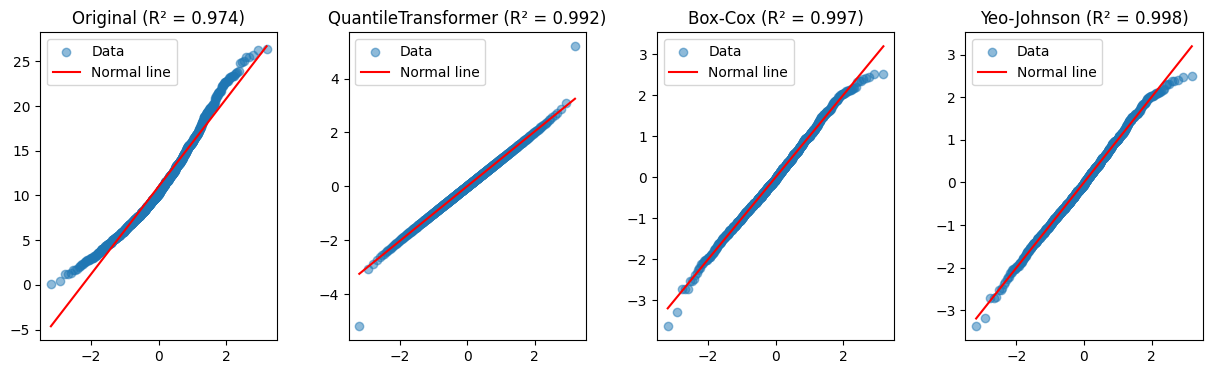

Best normalization algorithm: Yeo-Johnson (R² = 0.998)


In [410]:
evaluate_normalization(df_training_no_missing_values, 'Total Training Hours per Week')

Yeo-Johnson sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [411]:
# Yeo-Johnson Transformation für "Total Training Hours per Week"
pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
df_training_no_missing_values['Total Training Hours per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_training_no_missing_values[['Total Training Hours per Week']])
df_test_no_missing_values['Total Training Hours per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_test_no_missing_values[['Total Training Hours per Week']])

<h3>VO2 Max

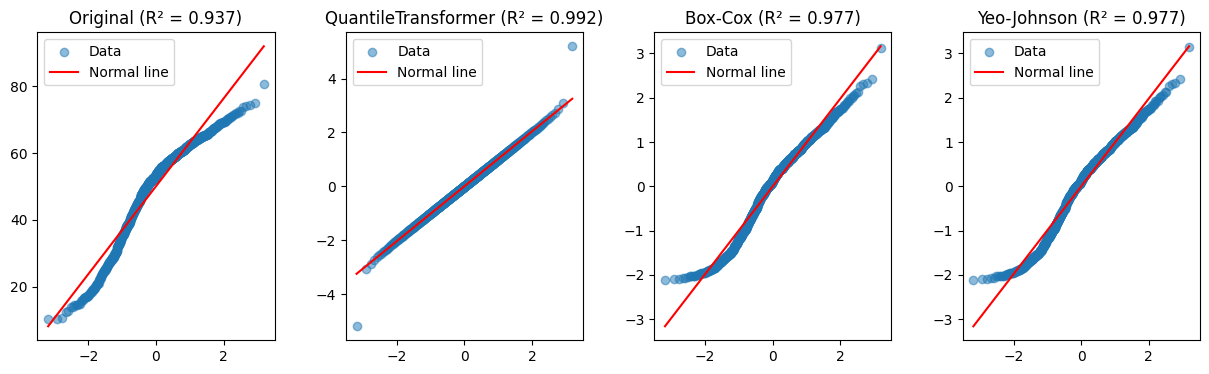

Best normalization algorithm: QuantileTransformer (R² = 0.992)


In [412]:
evaluate_normalization(df_training_no_missing_values, 'VO2 Max')

Quantile Transformer sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [413]:
# Quantile Transformation für "VO2 Max"
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=400)
df_training_no_missing_values['VO2 Max Normalver.'] = quantile_transformer.fit_transform(df_training_no_missing_values[['VO2 Max']])
df_test_no_missing_values['VO2 Max Normalver.'] = quantile_transformer.fit_transform(df_test_no_missing_values[['VO2 Max']])

<h3> 10k Running Time Prediction

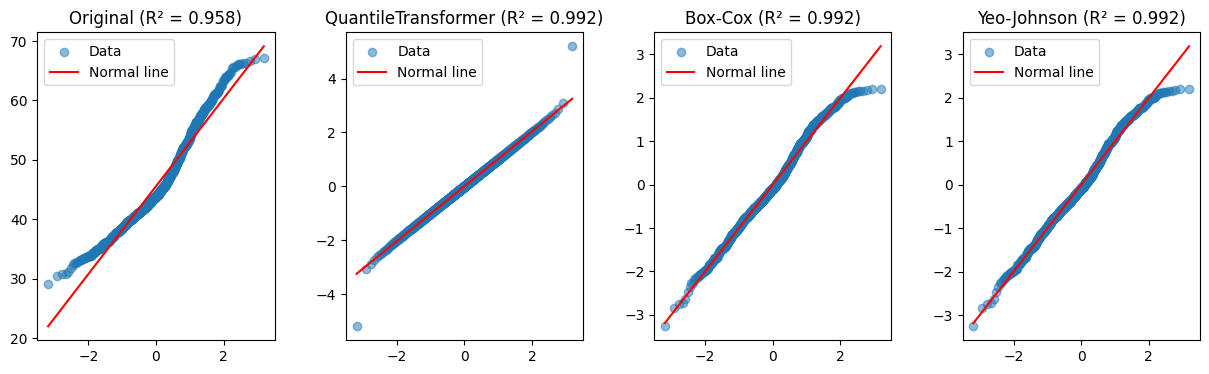

Best normalization algorithm: QuantileTransformer (R² = 0.992)


In [414]:
evaluate_normalization(df_training_no_missing_values, '10k Running Time Prediction')

Quantile Transformer sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [415]:
# Quantile Transformation für "10k Running Time Prediction"
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=400)
df_training_no_missing_values['10k Running Time Prediction Normalver.'] = quantile_transformer.fit_transform(df_training_no_missing_values[['10k Running Time Prediction']])
df_test_no_missing_values['10k Running Time Prediction Normalver.'] = quantile_transformer.fit_transform(df_test_no_missing_values[['10k Running Time Prediction']])

<h3> Calories Burned per Week

Box-Cox nicht möglich (enthält nicht-positive Werte).


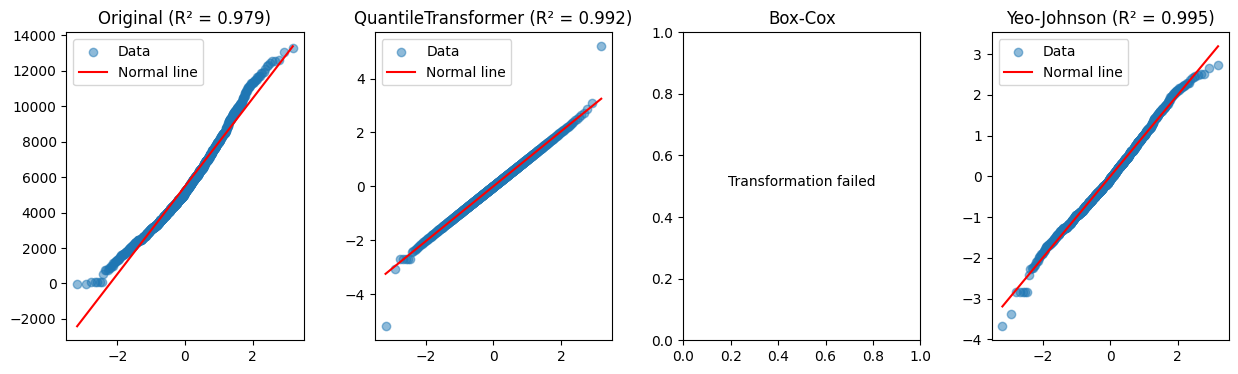

Best normalization algorithm: Yeo-Johnson (R² = 0.995)


In [416]:
evaluate_normalization(df_training_no_missing_values, 'Calories Burned per Week')

Yeo-Johnson sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [417]:
# Yeo-Johnson Transformation für "Calories Burned per Week"
pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
df_training_no_missing_values['Calories Burned per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_training_no_missing_values[['Calories Burned per Week']])
df_test_no_missing_values['Calories Burned per Week Normalver.'] = pt_yeo_johnson.fit_transform(df_test_no_missing_values[['Calories Burned per Week']])

<h3> Days since Update

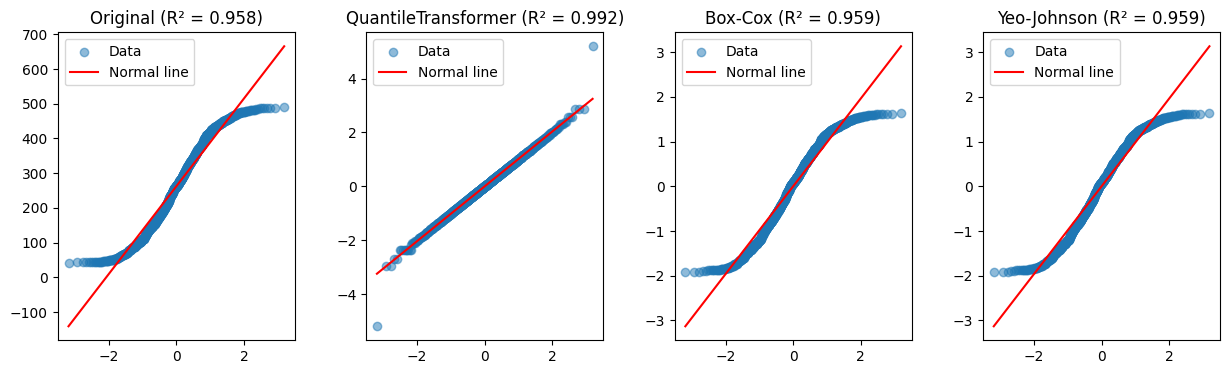

Best normalization algorithm: QuantileTransformer (R² = 0.992)


In [418]:
evaluate_normalization(df_training_no_missing_values, 'Days since Update')

Quantile Transformer sorgt für die beste Transformation, daher wird mit diesem Algorithmus die neue Spalte angelegt.

In [419]:
# Quantile Transformation für "Days since Update"
quantile_transformer = QuantileTransformer(
    output_distribution="normal", n_quantiles=400
)
df_training_no_missing_values["Days since Update Normalver."] = (
    quantile_transformer.fit_transform(
        df_training_no_missing_values[["Days since Update"]]
    )
)
df_test_no_missing_values["Days since Update Normalver."] = (
    quantile_transformer.fit_transform(df_test_no_missing_values[["Days since Update"]])
)

Benchmarking:

In [420]:
run_benchmark_lr(
    numeric_features=[
        "Age of customer",
        "Swimming Hours per Week Normalver.",
        "Biking Hours per Week Normalver.",
        "Running Hours per Week Normalver.",
        "Total Training Hours per Week Normalver.",
        "VO2 Max Normalver.",
        "10k Running Time Prediction Normalver.",
        "Calories Burned per Week Normalver.",
        "Days since Update Normalver.",
    ],
    categorical_features=[
        "Sex",
        "Ctry",
        "Town",
        "Preferred Training Daytime",
        "Subscription Type",
        "Goal of Training",
        "Synchronisation",
    ],
    run="LR Normalverteilung",
)

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151


In [421]:
run_svm_benchmark(df_training_no_missing_values,features = ["Age of customer",
        "Swimming Hours per Week Normalver.",
        "Biking Hours per Week Normalver.",
        "Running Hours per Week Normalver.",
        "Total Training Hours per Week Normalver.",
        "VO2 Max Normalver.",
        "10k Running Time Prediction Normalver.",
        "Calories Burned per Week Normalver.",
        "Days since Update Normalver."], target= 'User of latest model', run_svm = "SVM Normalverteilung")

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350


<h2> Numerische Features Standardizieren

Manche Algorithmen können nur/besser mit standardisierten Werten arbeiten, daher standardisiere ich alle numerischen Features.

In [422]:
def standardize_z_score(df):
    """
    Standardisiert angegebene Spalten des DataFrames mittels Z-Score Standardisierung
    und fügt die standardisierten Werte als neue Spalten hinzu.
    
    Parameter:
    df (pd.DataFrame): DataFrame, das die zu standardisierenden Spalten enthält
    
    Rückgabe:
    pd.DataFrame: Modifiziertes DataFrame mit den standardisierten Spalten
    """
    # Liste der zu standardisierenden Spalten
    spalten = [
        "Training Efficiency",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Days since Update"
    ]
    
    for spalte in spalten:
        if spalte in df.columns:
            # Berechnung von Mittelwert und Standardabweichung
            mean_value = df[spalte].mean()
            std_value = df[spalte].std()
            
            # Vermeidung von Division durch Null (falls Standardabweichung 0)
            if std_value != 0:
                df[spalte + " Standardisiert"] = (df[spalte] - mean_value) / std_value
            else:
                df[spalte + " Standardisiert"] = 0.0
        else:
            print(f"Warnung: Spalte '{spalte}' nicht im DataFrame gefunden.")
    
    return df

# Anwendung der Funktion
df_training_no_missing_values = standardize_z_score(df_training_no_missing_values)
df_test_no_missing_values = standardize_z_score(df_test_no_missing_values)

Benchmarking:

In [423]:
run_benchmark_lr(
    numeric_features=[
        "Age of customer",
        "Swimming Hours per Week Standardisiert",
        "Biking Hours per Week Standardisiert",
        "Running Hours per Week Standardisiert",
        "Total Training Hours per Week Standardisiert",
        "VO2 Max Standardisiert",
        "10k Running Time Prediction Standardisiert",
        "Calories Burned per Week Standardisiert",
        "Days since Update Standardisiert",
    ],
    categorical_features=[
        "Sex",
        "Ctry",
        "Town",
        "Preferred Training Daytime",
        "Subscription Type",
        "Goal of Training",
        "Synchronisation",
    ],
    run="LR Standardisiert",
)

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325


In [424]:
run_svm_benchmark(df_training_no_missing_values,features = [
        "Age of customer",
        "Swimming Hours per Week Standardisiert",
        "Biking Hours per Week Standardisiert",
        "Running Hours per Week Standardisiert",
        "Total Training Hours per Week Standardisiert",
        "VO2 Max Standardisiert",
        "10k Running Time Prediction Standardisiert",
        "Calories Burned per Week Standardisiert",
        "Days since Update Standardisiert",
    ], target= 'User of latest model', run_svm = "SVM Standardisiert")

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886


<h2> Numerische Features Normalisieren (Min-Max)

Manche Algorithmen können nur/besser mit Normalisierten Werten arbeiten, daher standardisiere ich alle numerischen Features.

In [425]:
def scale_min_max(df):
    """
    Skaliert angegebene Spalten des DataFrames mittels Min-Max-Skalierung (Bereich 0-1)
    und fügt die skalierten Werte als neue Spalten hinzu.
    
    Parameter:
    df (pd.DataFrame): DataFrame, das die zu skalierenden Spalten enthält
    
    Rückgabe:
    pd.DataFrame: Modifiziertes DataFrame mit den skalierten Spalten
    """
    # Liste der zu skalierenden Spalten
    spalten = [
        "Training Efficiency",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Days since Update"
    ]
    
    for spalte in spalten:
        if spalte in df.columns:
            # Min-Max-Skalierung
            min_wert = df[spalte].min()
            max_wert = df[spalte].max()
            
            # Vermeidung von Division durch Null (falls min == max)
            if max_wert != min_wert:
                df[spalte + " Min_Max"] = (df[spalte] - min_wert) / (max_wert - min_wert)
            else:
                # Falls alle Werte identisch sind, setze auf 0
                df[spalte + " Min_Max"] = 0.0
        else:
            print(f"Warnung: Spalte '{spalte}' nicht im DataFrame gefunden.")
    
    return df

# Anwendung der Funktion
df_training_no_missing_values = scale_min_max(df_training_no_missing_values)
df_test_no_missing_values = scale_min_max(df_test_no_missing_values)

Benchmarking:

In [426]:
run_benchmark_lr(
    numeric_features=[
        "Age of customer",
        "Swimming Hours per Week Min_Max",
        "Biking Hours per Week Min_Max",
        "Running Hours per Week Min_Max",
        "Total Training Hours per Week Min_Max",
        "VO2 Max Min_Max",
        "10k Running Time Prediction Min_Max",
        "Calories Burned per Week Min_Max",
        "Days since Update Min_Max",
    ],
    categorical_features=[
        "Sex",
        "Ctry",
        "Town",
        "Preferred Training Daytime",
        "Subscription Type",
        "Goal of Training",
        "Synchronisation",
    ],
    run="LR Normalisiert (Min-Max)",
)

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886
8,LR Normalisiert (Min-Max),0.733333,0.732222,0.733333,0.730797


In [427]:
run_svm_benchmark(df_training_no_missing_values,features = [
        "Age of customer",
        "Swimming Hours per Week Min_Max",
        "Biking Hours per Week Min_Max",
        "Running Hours per Week Min_Max",
        "Total Training Hours per Week Min_Max",
        "VO2 Max Min_Max",
        "10k Running Time Prediction Min_Max",
        "Calories Burned per Week Min_Max",
        "Days since Update Min_Max",
    ], target= 'User of latest model', run_svm = "SVM Normalisiert (Min-Max)")

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886
8,LR Normalisiert (Min-Max),0.733333,0.732222,0.733333,0.730797
9,SVM Normalisiert (Min-Max),0.635897,0.631921,0.635897,0.624644


<h2> Numerische Features Transformation visualisieren

Hier visualisiere ich, wie die jeweiligen Transformationen die Verteilung der numerischen Features verändert hat.

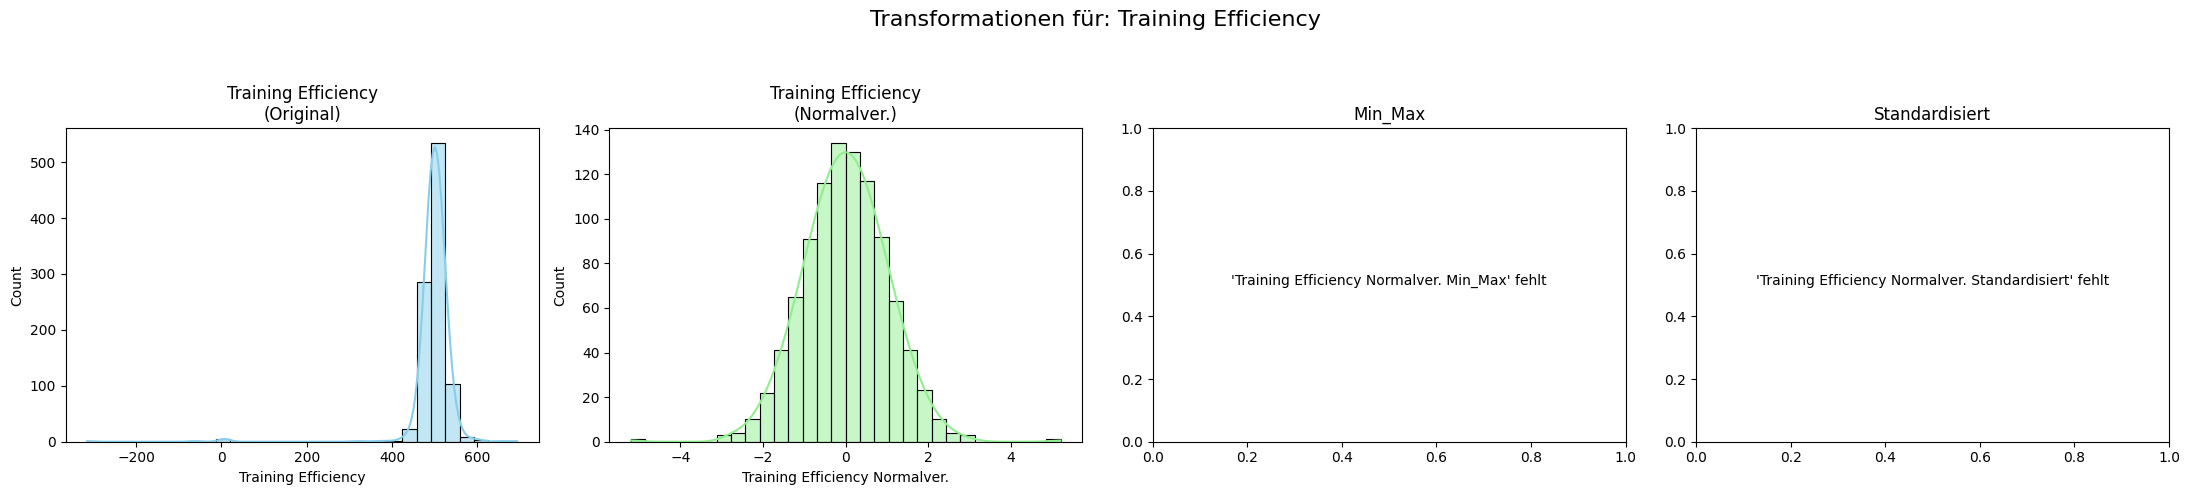

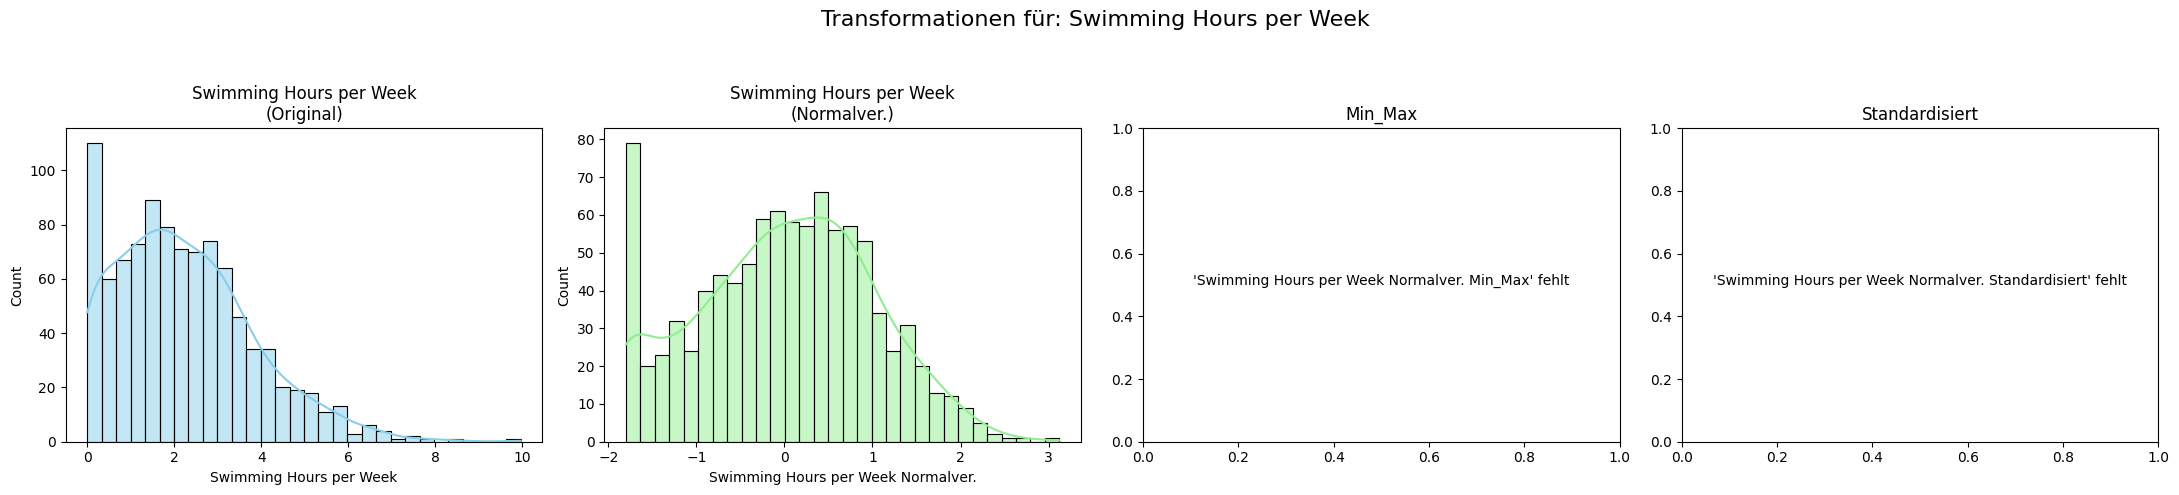

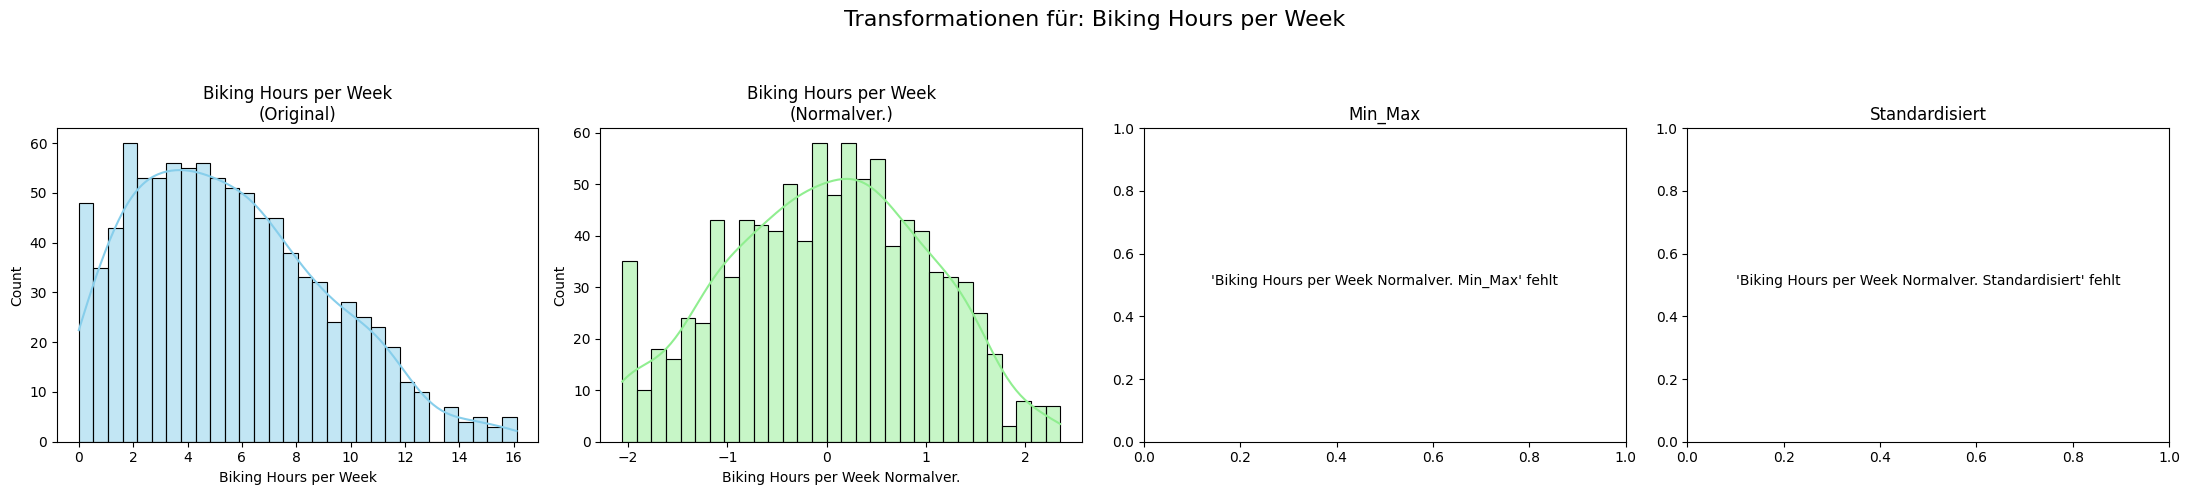

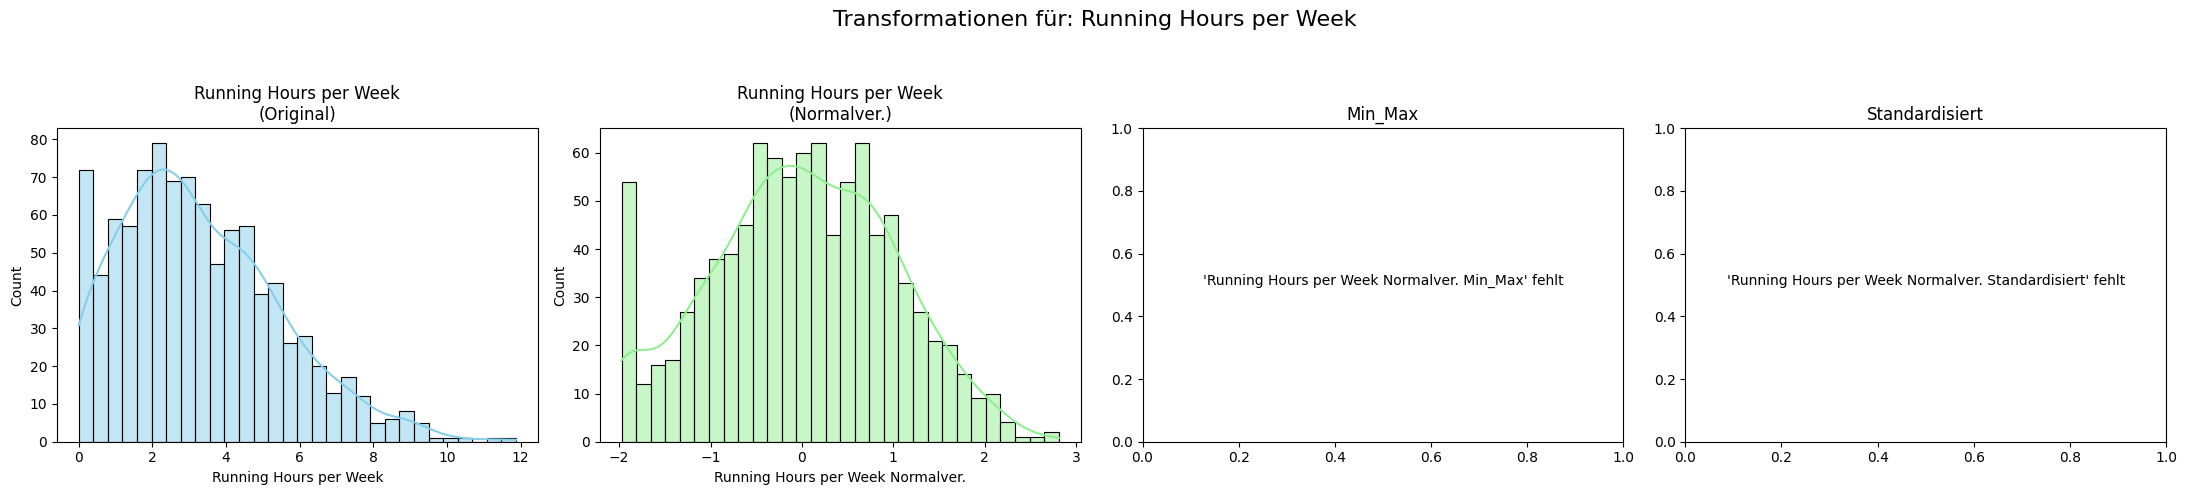

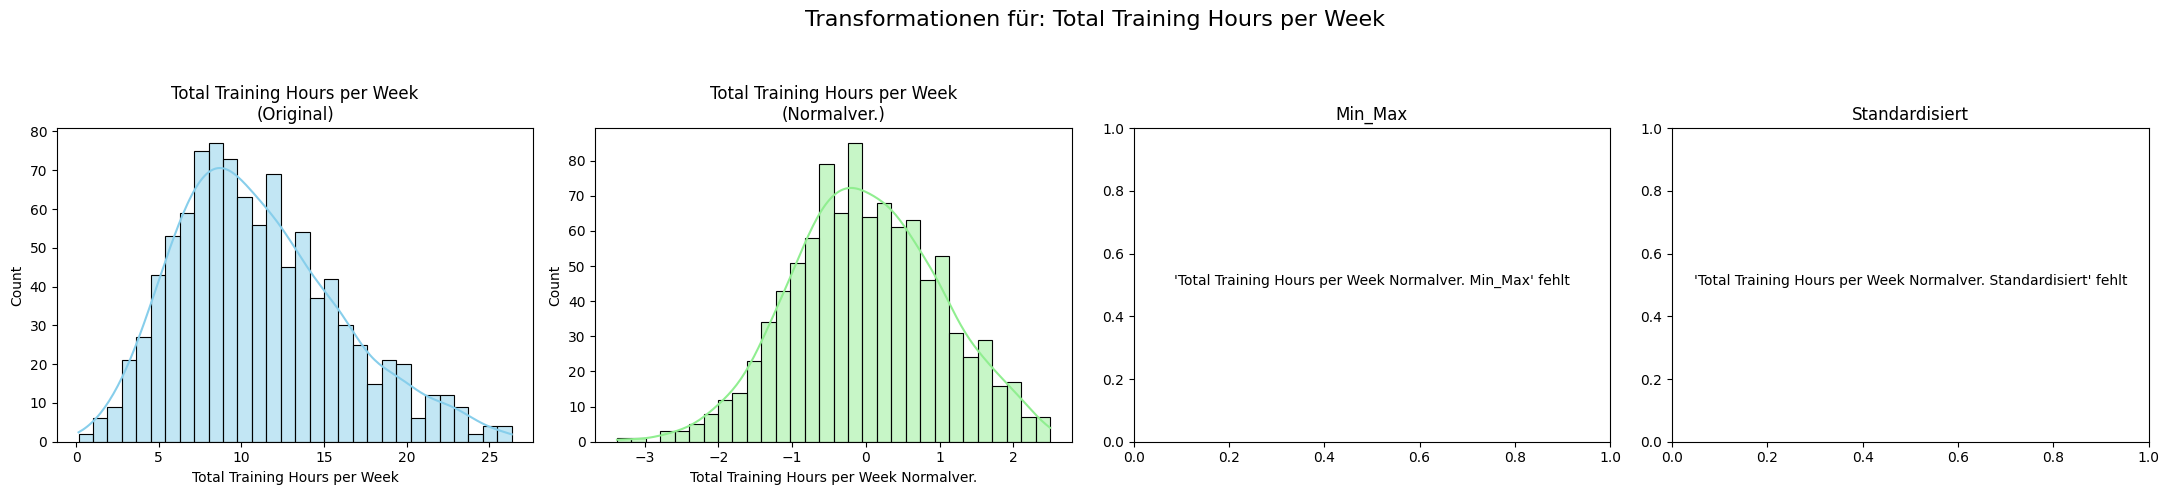

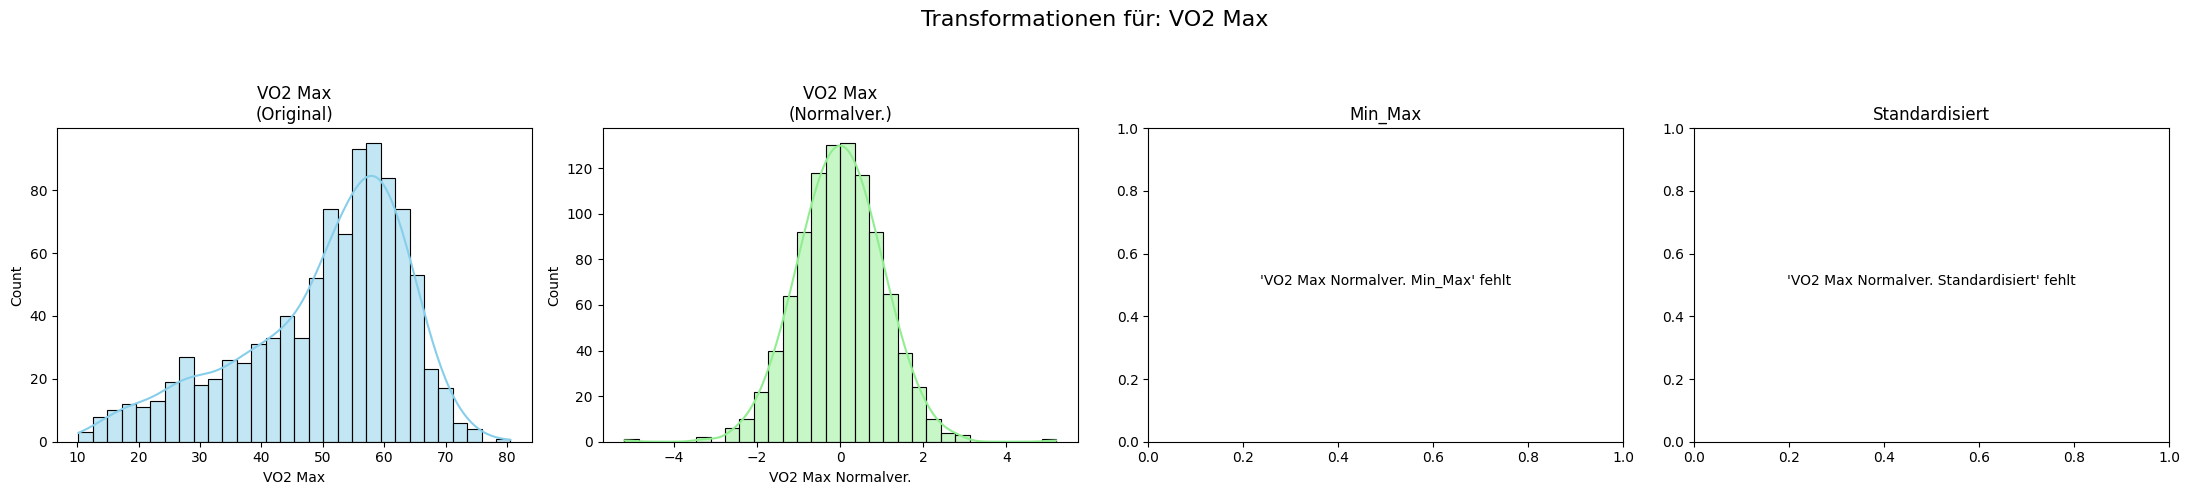

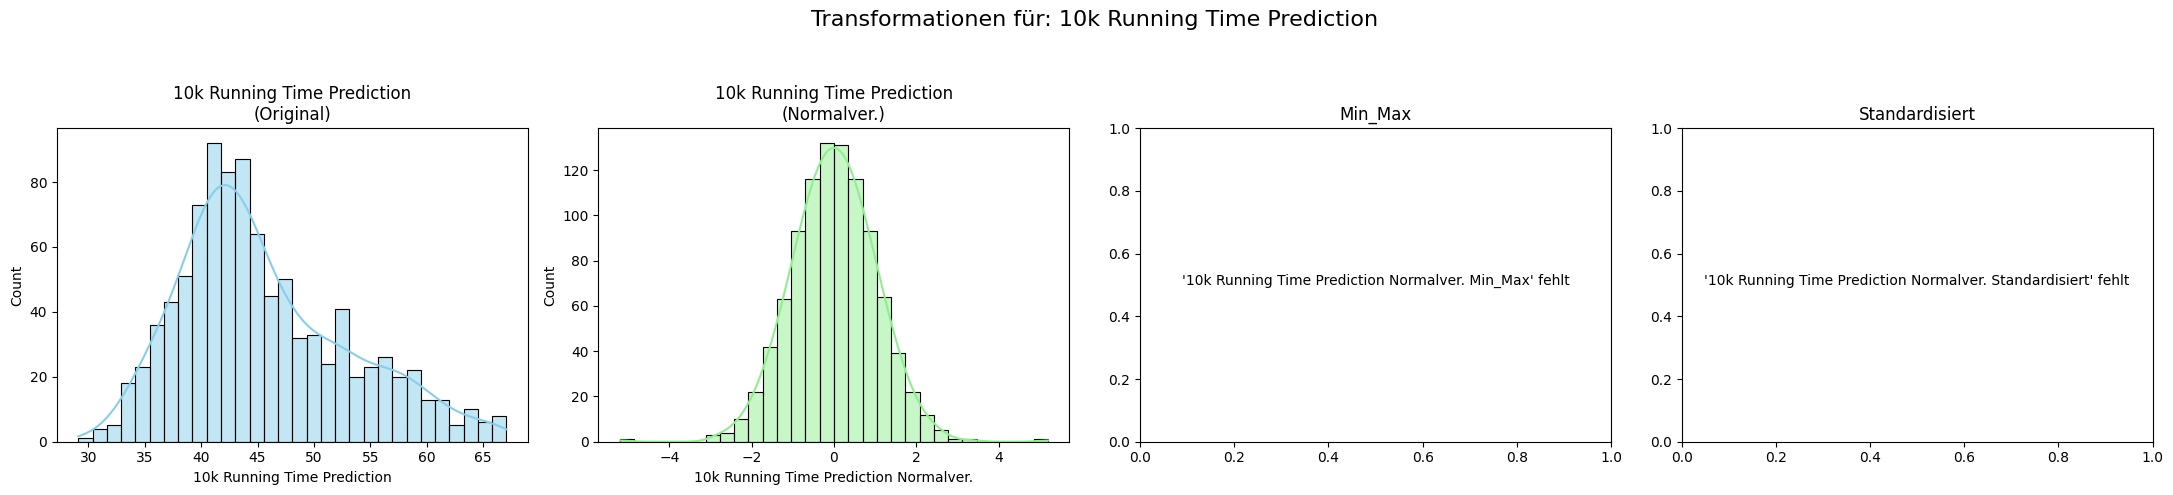

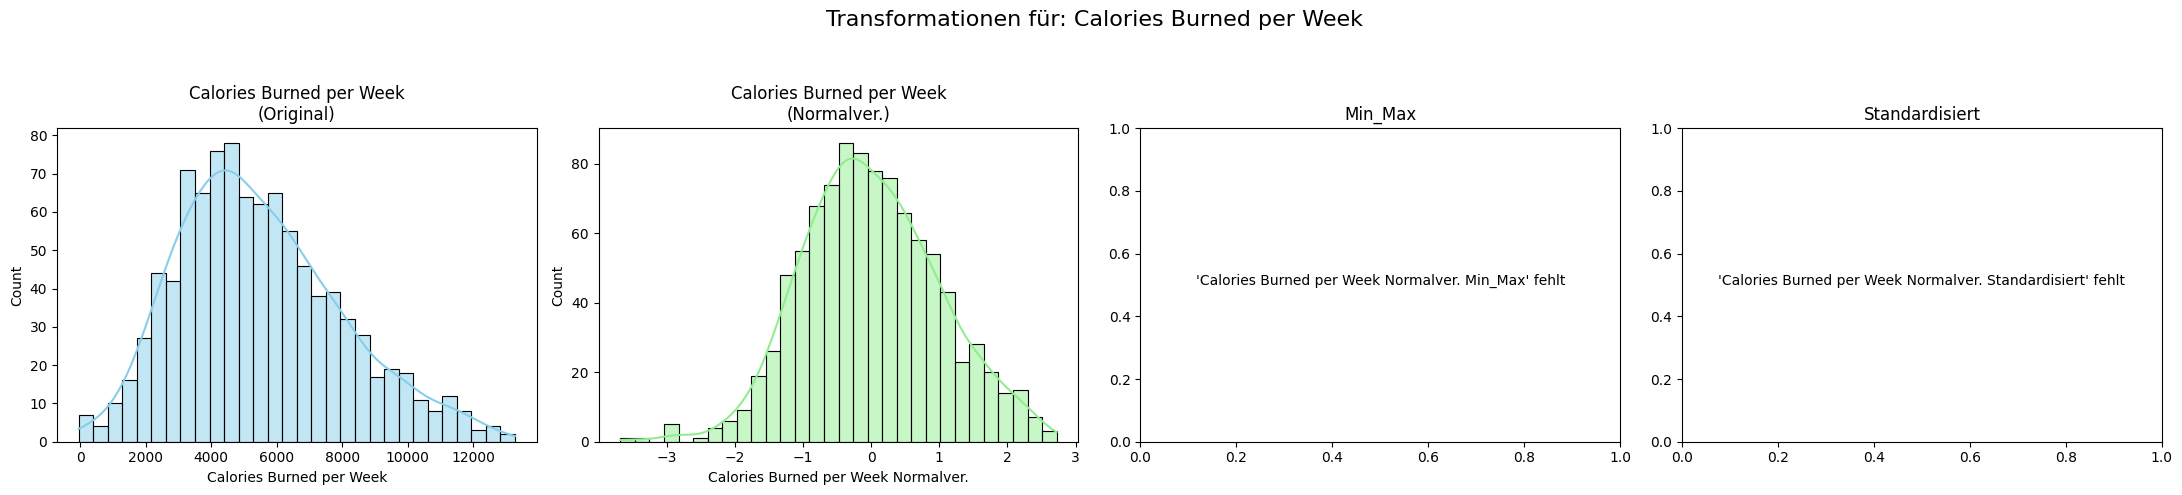

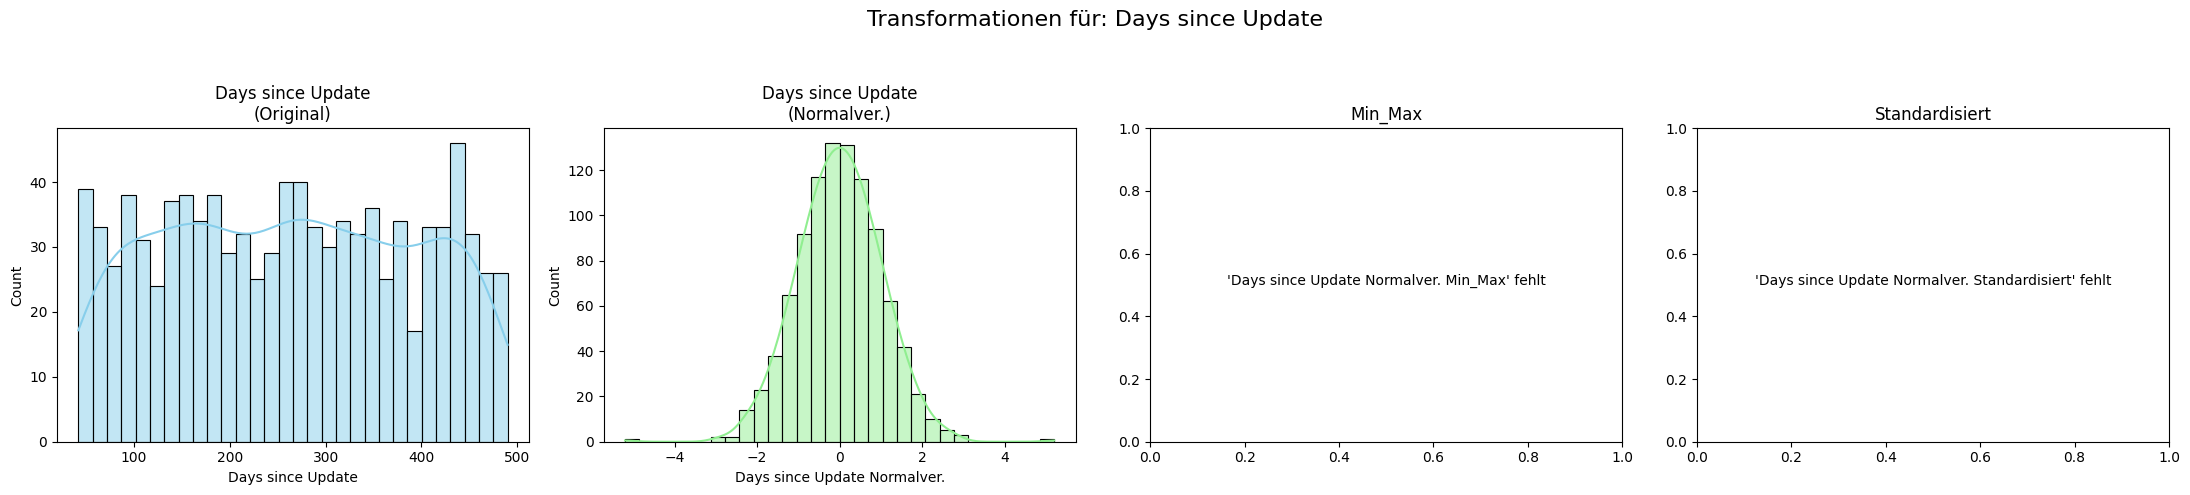

In [428]:
def plot_transformations(df):
    """
    Visualisiert die Transformationen der numerischen Features.
    
    Für jedes Feature (Original, Normalver., Min_Max, Standardisiert) wird ein Plot
    erstellt, der die jeweiligen Verteilungen gegenüberstellt.
    
    Erwartet wird, dass das DataFrame folgende Spalten enthält:
      - Originaldaten: z. B. "Swimming Hours per Week"
      - Vorverarbeitete (normalisierte) Daten: z. B. "Swimming Hours per Week Normalver."
      - Min-Max-transformierte Daten: z. B. "Swimming Hours per Week Normalver. Min_Max"
      - Standardisierte Daten: z. B. "Swimming Hours per Week Normalver. Standardisiert"
    """
    # Liste der Basis-Features, die transformiert wurden
    base_features = [
        "Training Efficiency",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Days since Update"
    ]
    
    # Iteriere über alle Basis-Features
    for feature in base_features:
        # Definiere die Namen der zugehörigen Spalten
        original_col = feature  # Originaldaten
        normalver_col = feature + " Normalver."
        minmax_col    = feature + " Normalver. Min_Max"
        std_col       = feature + " Normalver. Standardisiert"
        
        # Erstelle eine Figure mit 1 Zeile und 4 Spalten
        fig, axes = plt.subplots(1, 4, figsize=(22, 5))
        
        # --- Originaldaten plotten
        if original_col in df.columns:
            sns.histplot(df[original_col], bins=30, kde=True, ax=axes[0], color='skyblue')
            axes[0].set_title(f"{feature}\n(Original)")
            axes[0].set_xlabel(feature)
        else:
            axes[0].text(0.5, 0.5, f"'{original_col}' fehlt", ha='center')
            axes[0].set_title("Originaldaten")
        
        # --- Normalver. Daten plotten
        if normalver_col in df.columns:
            sns.histplot(df[normalver_col], bins=30, kde=True, ax=axes[1], color='lightgreen')
            axes[1].set_title(f"{feature}\n(Normalver.)")
            axes[1].set_xlabel(normalver_col)
        else:
            axes[1].text(0.5, 0.5, f"'{normalver_col}' fehlt", ha='center')
            axes[1].set_title("Normalver.")
        
        # --- Min-Max-transformierte Daten plotten
        if minmax_col in df.columns:
            sns.histplot(df[minmax_col], bins=30, kde=True, ax=axes[2], color='orange')
            axes[2].set_title(f"{feature}\n(Min_Max)")
            axes[2].set_xlabel(minmax_col)
        else:
            axes[2].text(0.5, 0.5, f"'{minmax_col}' fehlt", ha='center')
            axes[2].set_title("Min_Max")
        
        # --- Standardisierte Daten plotten
        if std_col in df.columns:
            sns.histplot(df[std_col], bins=30, kde=True, ax=axes[3], color='salmon')
            axes[3].set_title(f"{feature}\n(Standardisiert)")
            axes[3].set_xlabel(std_col)
        else:
            axes[3].text(0.5, 0.5, f"'{std_col}' fehlt", ha='center')
            axes[3].set_title("Standardisiert")
        
        # Gesamttitel für den Vergleich
        fig.suptitle(f"Transformationen für: {feature}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

# Anwendung des Plotting-Tools:
plot_transformations(df_training_no_missing_values)


Die Histogramme von Normalver. und Standardisiert sehen sehr ähnlich aus. Die Werte sind jedoch unterschiedlich, was folgender Code zeigt:

In [429]:
df_training_no_missing_values[
    [
        "VO2 Max",
        "VO2 Max Normalver.",
        "VO2 Max Min_Max",
        "VO2 Max Standardisiert",
    ]
].head()

,VO2 Max,VO2 Max Normalver.,VO2 Max Min_Max,VO2 Max Standardisiert
ID,,,,
C0001,23.08,-1.625392,0.182878,-1.993361
C0003,39.04,-0.795943,0.409841,-0.813458
C0004,71.59,2.346735,0.872725,1.592921
C0005,49.09,-0.338025,0.552759,-0.070475
C0006,13.91,-2.537509,0.052474,-2.671287


<h1> Kategoriale Features transformieren

<h3> Target encoding </h3>

Anhand EDA überlegen, für welche Features Target Encoding Sinn macht:

- `Sex`, `Preferred Training Daytime`, `Color of Watch`:
    - Kaum Unterschiede in den Anteiligkeiten je nach Label erkennbar
    - Keinen Einfluss auf Label
    - -> nicht sinnvoll

- `Synchronisation`
    - Unterschiede in den Anteiligkeiten je nach Label erkennbar
    - Keinen Einfluss auf Label
    - -> nicht sinnvoll

- `Ctry`, `Town`,  `Goal of Training`, `Subscription Type`, `Support Cases of Customer`, `Customer Years`
    - Unterschiede in den Anteiligkeiten je nach Label erkennbar
    - Einfluss auf Label
    - -> Target encoding sinnvoll

Aber:
`Ctry` und `Town` sind kollinear, daher wird das Target encoding nur für `Town` gemacht.

D.H. auf die Spalten `Town`,  `Goal of Training`, `Subscription Type`, `Support Cases of Customer`, `Customer Years` wird im folgenden Target encoding angewand:



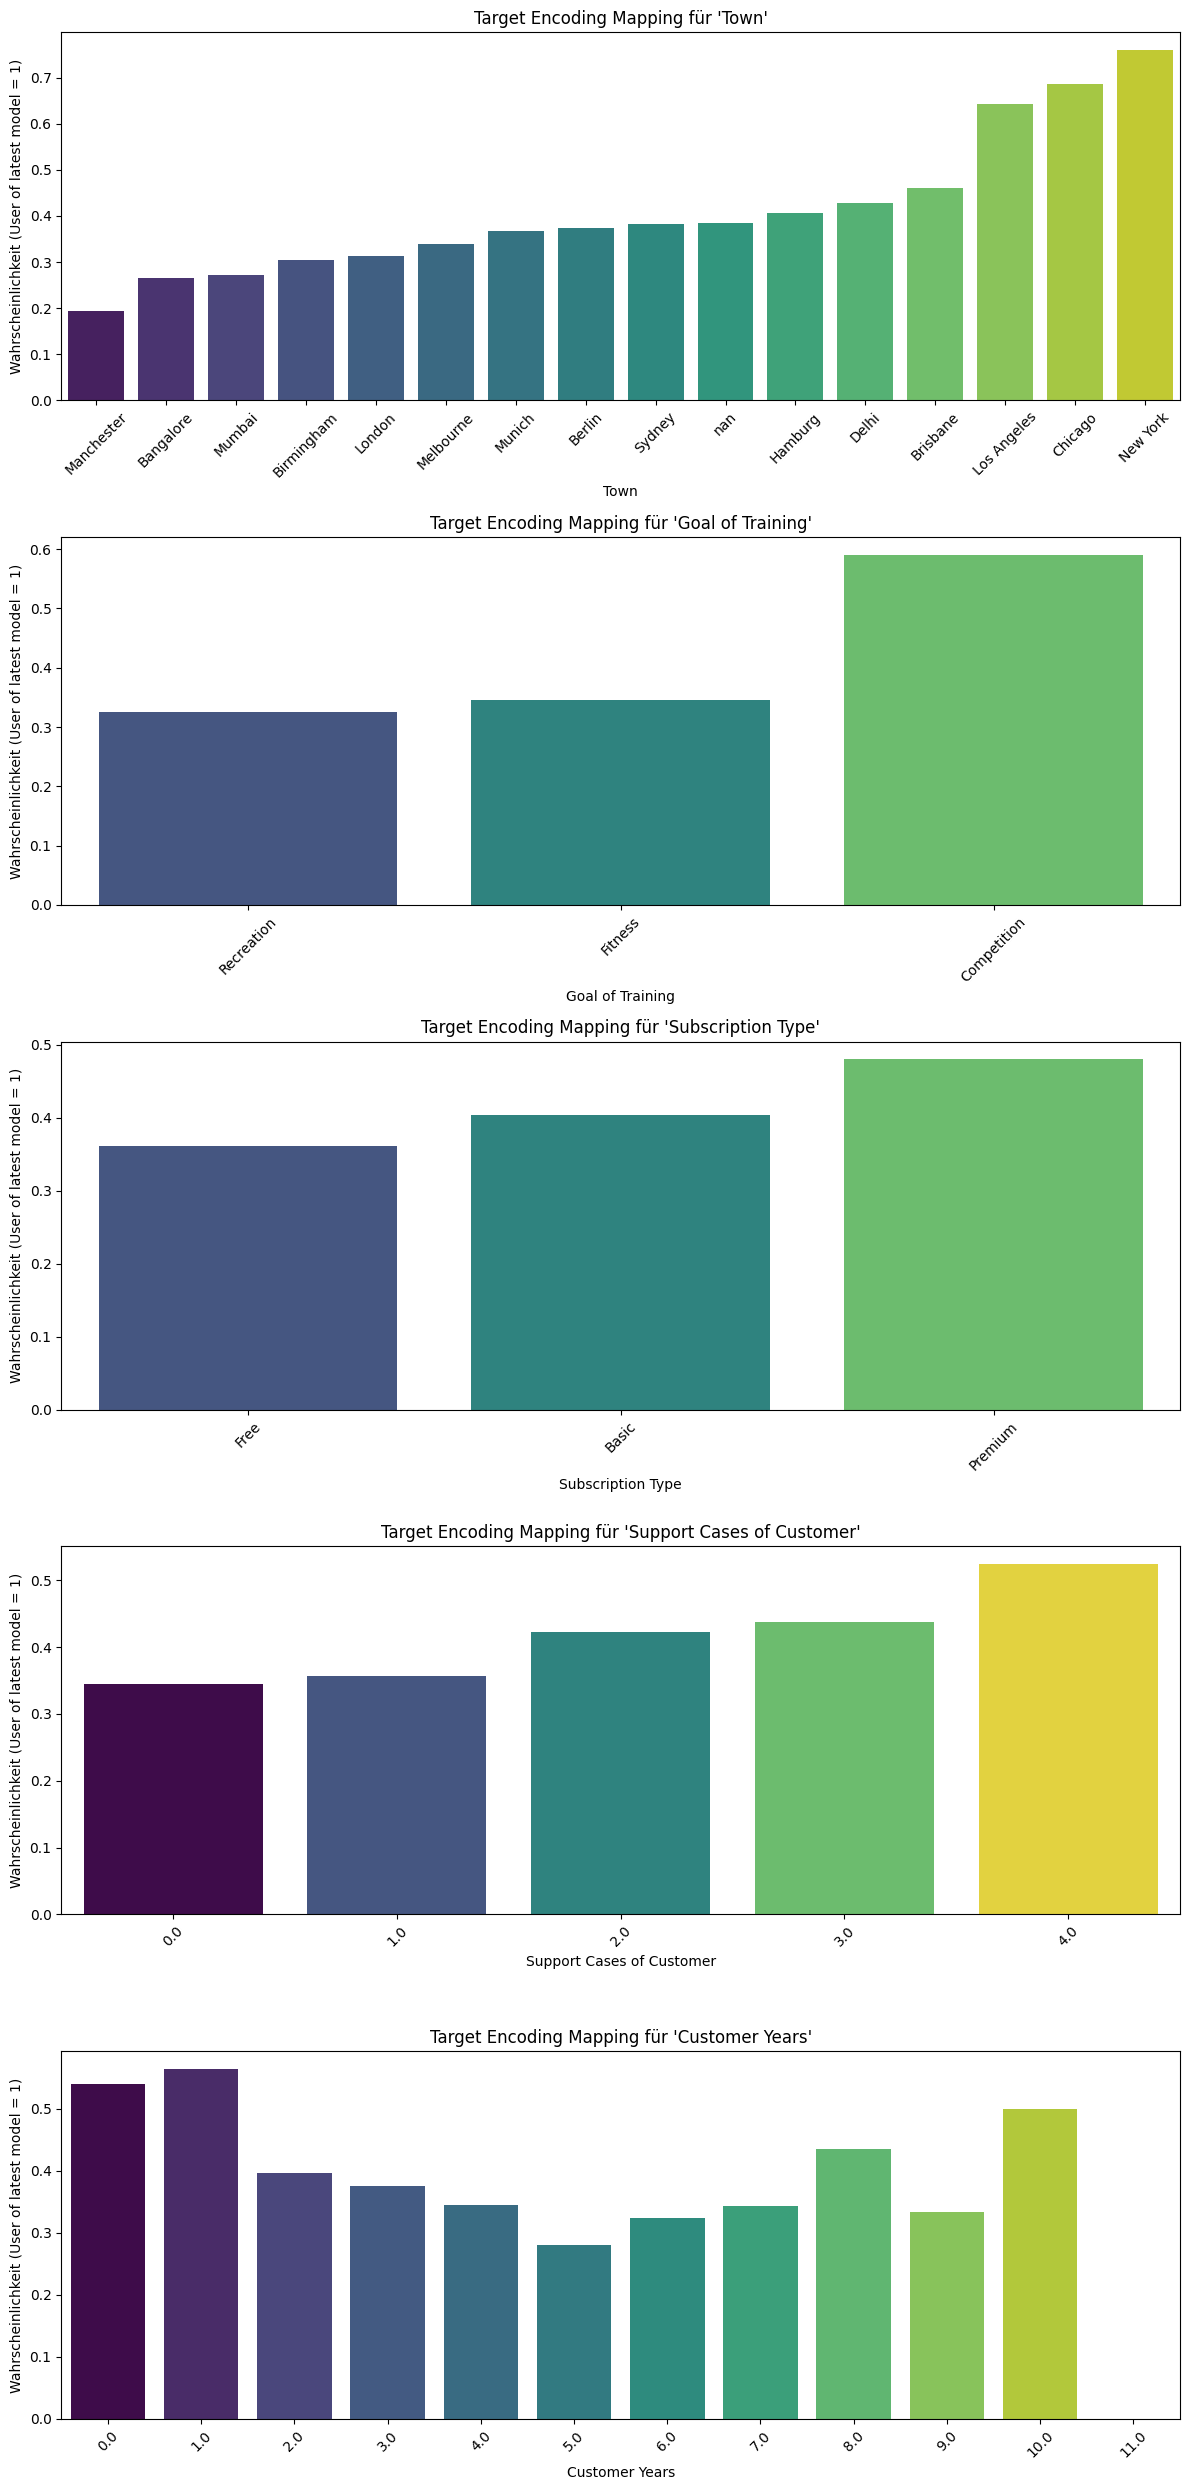

In [430]:
columns_to_encode = [
    "Town",
    "Goal of Training",
    "Subscription Type",
    "Support Cases of Customer",
    "Customer Years",
]

# train data
for col in columns_to_encode:
    mapping = df_training_no_missing_values.groupby(col)["User of latest model"].mean()
    new_col_name = col + " target encoded"
    df_training_no_missing_values[new_col_name] = df_training_no_missing_values[col].map(mapping)
    
# test data
for col in columns_to_encode:
    mapping = df_test_no_missing_values.groupby(col)["User of latest model"].mean()
    new_col_name = col + " target encoded"
    df_test_no_missing_values[new_col_name] = df_test_no_missing_values[col].map(mapping)

# -------------------------------------------------------------------
# 1. Visualisierung: Mapping der Kategorien (Balkendiagramm)
# -------------------------------------------------------------------
num_plots = len(columns_to_encode)
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 5 * num_plots))
if num_plots == 1:
    axes = [axes]  # Sicherstellen, dass axes iterierbar ist

for ax, col in zip(axes, columns_to_encode):
    # Berechne das Mapping (Kategorie -> bedingte Wahrscheinlichkeit)
    mapping = df_training_no_missing_values.groupby(col)["User of latest model"].mean().sort_values()
    
    sns.barplot(x=mapping.index, y=mapping.values, ax=ax, palette="viridis", hue=mapping.index, dodge=False, legend=False)
    ax.set_title(f"Target Encoding Mapping für '{col}'")
    ax.set_xlabel(col)
    ax.set_ylabel("Wahrscheinlichkeit (User of latest model = 1)")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Benchmarking:

In [431]:
run_benchmark_lr(
    numeric_features=[
        "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Customer Years",
        "Days since Update",
        "Town target encoded",
        "Subscription Type target encoded",
        "Goal of Training target encoded",
    ],
    categorical_features=[
        "Sex",
        "Ctry",
        "Town",
        "Support Cases of Customer",
        "Goal of Training",
        "Preferred Training Daytime",
        "Subscription Type",
        "Synchronisation",
    ],
    run="LR Target Encoded",
)

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886
8,LR Normalisiert (Min-Max),0.733333,0.732222,0.733333,0.730797
9,SVM Normalisiert (Min-Max),0.635897,0.631921,0.635897,0.624644


In [432]:
run_svm_benchmark(df_training_no_missing_values,features = [
        "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Customer Years",
        "Days since Update",
        "Town target encoded",
        "Subscription Type target encoded",
        "Goal of Training target encoded",
    ], target= 'User of latest model', run_svm = "SVM Target Encoded")

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886
8,LR Normalisiert (Min-Max),0.733333,0.732222,0.733333,0.730797
9,SVM Normalisiert (Min-Max),0.635897,0.631921,0.635897,0.624644


<h3> Ordinal Encoding </h3>

Die Spalte "Subscription Type" enthält die Werte Free, Basic und Premium. Da das einer Reihenfolge enstpricht (Aufsteigend teurer und mehr Features), könnte eine ordinale Codierung hier Sinn machen.

In [433]:
# Ordinal Encoding für die Spalte "Subscription Type"
ordinal_mapping = {"Free": 1, "Basic": 2, "Premium": 3}
df_training_no_missing_values["Subscription Type Ordinal"] = (
    df_training_no_missing_values["Subscription Type"].map(ordinal_mapping)
)
df_test_no_missing_values["Subscription Type Ordinal"] = df_test_no_missing_values[
    "Subscription Type"
].map(ordinal_mapping)

Benchmarking:

In [434]:
run_benchmark_lr(
    numeric_features=[
        "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Days since Update",
        "Subscription Type Ordinal",
    ],
    categorical_features=[
        "Sex",
        "Ctry",
        "Preferred Training Daytime",
        "Synchronisation",
        "Town",
        "Subscription Type",
        "Goal of Training",
    ],
    run="LR Ordinal Encoded",
)

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886
8,LR Normalisiert (Min-Max),0.733333,0.732222,0.733333,0.730797
9,SVM Normalisiert (Min-Max),0.635897,0.631921,0.635897,0.624644


In [435]:
run_svm_benchmark(df_training_no_missing_values,features = [
        "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Days since Update",
        "Subscription Type Ordinal",
    ], target= 'User of latest model', run_svm = "SVM Ordinal Encoded")

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886
8,LR Normalisiert (Min-Max),0.733333,0.732222,0.733333,0.730797
9,SVM Normalisiert (Min-Max),0.635897,0.631921,0.635897,0.624644


<h2> Binning </h2>
Die Werte des Features "Age of Customer" sind stark ungleich verteilt (siehe EDA). Daher wende ich Binning an, um 10 Altersgruppen zu erstellen, in denen jeweils etwa gleich viele Nutzer sind. Das wird als neues Feature gespeichert.

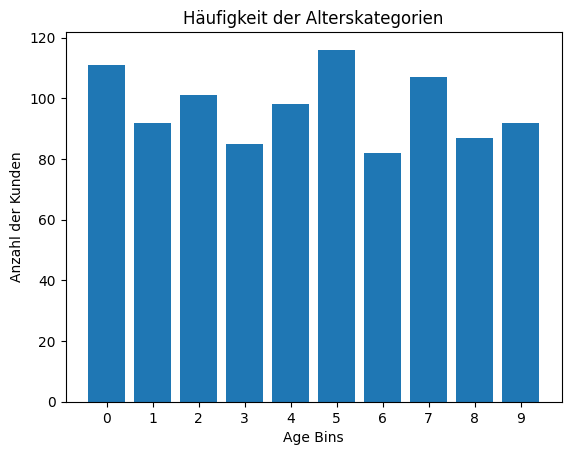

In [436]:
# train data
df_training_no_missing_values['Age of customer Bin'] = pd.qcut(
    df_training_no_missing_values['Age of customer'], 
    q=10,
    labels=False  # Numerische Labels für die Bins (0 bis 9)
)

# test data
df_test_no_missing_values['Age of customer Bin'] = pd.qcut(
    df_test_no_missing_values['Age of customer'], 
    q=10,
    labels=False  # Numerische Labels für die Bins (0 bis 9)
)

# Häufigkeit der Bins berechnen
bin_counts = df_training_no_missing_values['Age of customer Bin'].value_counts().sort_index()

# Balkendiagramm erstellen
plt.bar(bin_counts.index, bin_counts.values, tick_label=bin_counts.index)
plt.xlabel('Age Bins')
plt.ylabel('Anzahl der Kunden')
plt.title('Häufigkeit der Alterskategorien')
plt.show()

Benchmarking:

In [437]:
run_benchmark_lr(
    numeric_features=[
        "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Days since Update",
        "Age of customer Bin",
    ],
    categorical_features=[
        "Sex",
        "Ctry",
        "Preferred Training Daytime",
        "Synchronisation",
        "Town",
        "Subscription Type",
        "Goal of Training",
    ],
    run="LR Binning",
)

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886
8,LR Normalisiert (Min-Max),0.733333,0.732222,0.733333,0.730797
9,SVM Normalisiert (Min-Max),0.635897,0.631921,0.635897,0.624644


In [438]:
run_svm_benchmark(df_training_no_missing_values,features = [
         "Age of customer",
        "Swimming Hours per Week",
        "Biking Hours per Week",
        "Running Hours per Week",
        "Total Training Hours per Week",
        "VO2 Max",
        "10k Running Time Prediction",
        "Calories Burned per Week",
        "Days since Update",
        "Age of customer Bin"
    ], target= 'User of latest model', run_svm = "SVM Binning")

,Run,Accuracy,Precision,Recall,F1-Score
0,LR Baseline,0.738462,0.737668,0.738462,0.735642
1,SVM Baseline,0.656410,0.672676,0.656410,0.626332
2,LR Feature Engineering,0.733333,0.732222,0.733333,0.730797
3,SVM Feature Engineering,0.651282,0.667292,0.651282,0.619455
4,LR Normalverteilung,0.743590,0.742735,0.743590,0.741151
5,SVM Normalverteilung,0.697436,0.695652,0.697436,0.693350
6,LR Standardisiert,0.748718,0.748853,0.748718,0.745325
7,SVM Standardisiert,0.671795,0.669096,0.671795,0.666886
8,LR Normalisiert (Min-Max),0.733333,0.732222,0.733333,0.730797
9,SVM Normalisiert (Min-Max),0.635897,0.631921,0.635897,0.624644


<h2> Benchmarking Auswertung

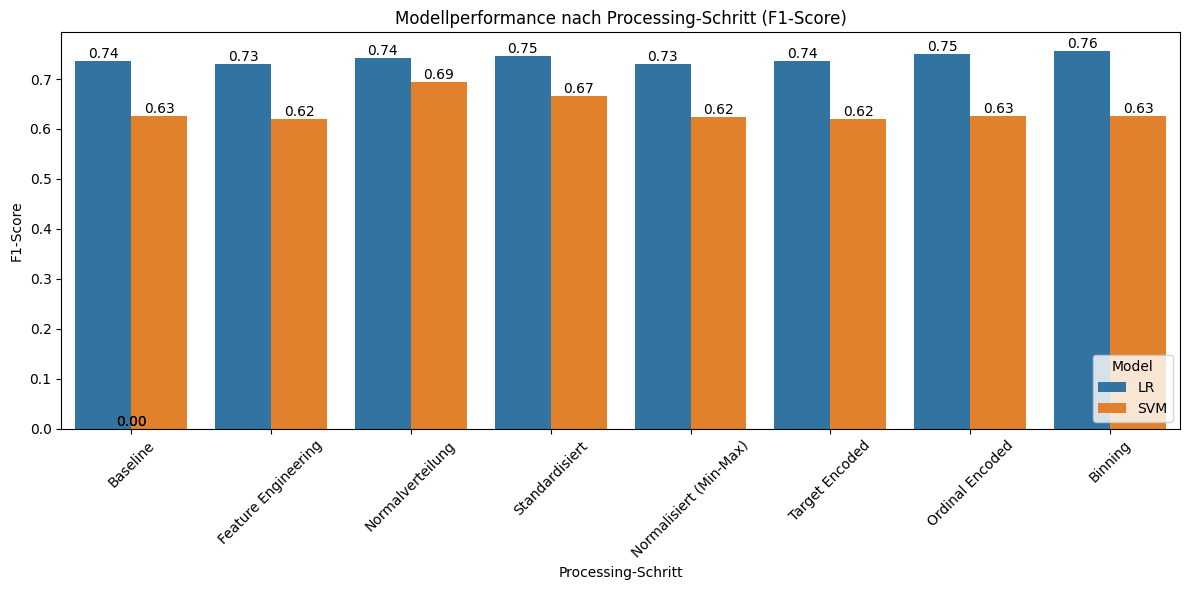

In [439]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extrahiere 'Model' und 'Processing' aus der 'Run'-Spalte
benchmark_df[['Model', 'Processing']] = benchmark_df['Run'].str.split(n=1, expand=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Processing', y='F1-Score', hue='Model', data=benchmark_df)

# Werte über die Balken schreiben
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',  # Wert mit zwei Dezimalstellen
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position leicht über dem Balken
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.title('Modellperformance nach Processing-Schritt (F1-Score)')
plt.xlabel('Processing-Schritt')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Das Benchmarking zeigt, dass die Schritte der Datenverarbeitung für die Logistische Regression nicht viel gebracht haben. Das war zu erwarten, da logistische Regression mit nicht-skalierten und nicht-normalisierten Daten gut umgehen kann. Beim Target-Encoding, Ordinal Encoding und Binning wurden jeweils nur wenige Features transformiert, weshalb deren veränderung wahrscheinlich nicht ins Gewicht fällt.

Die SVM-Modelle hat sich bei der Transformation der Daten hin zur Normalverteilung und bei der Standardisierung deutlich verbessert. Die anderen Schritte haben keine Verbesserung gebracht.

Gründe, weshalb sich der F1 Score nicht noch weiter verbessert hat, könnten folgende sein:

Veränderung der Datenstruktur:
Manche Transformationen (z. B. Box-Cox oder Yeo-Johnson) können zwar dazu beitragen, die Daten normalverteilter zu machen, verändern aber gleichzeitig die ursprünglichen Beziehungen und Abstände zwischen den Datenpunkten. Da SVMs auf Abstandsmaßen basieren, kann eine Veränderung dieser Abstände die Fähigkeit des Modells beeinträchtigen, die Klassen optimal zu trennen.

Verlust von relevanter Information:
Manche Transformationen können in bestimmten Fällen wichtige Strukturen oder Muster in den Daten „glätten“. Wenn die ursprüngliche Verteilung der Features eine wichtige Information für die Klassifikation enthält (z. B. Ausreißer oder asymmetrische Verteilungen, die zur Trennung der Klassen beitragen), kann das Erzwingen einer Normalverteilung diese Informationen reduzieren.

Und vor allem: 

Überflüssige Features/Ungeeignete Featurekombinationen:
Die Benchmarkings basieren auf den im jeweiligen processing Schritt neu erzeugten Features und ignorieren teils Features aus anderen Processing Schritten. Es ist möglich, dass eine Kombination aus Features aus unterschiedlichen Processing Schritten zu einer besseren Vorhersage führt (z.B. könnte es sein, dass das Feature Trainingszeit standardisiert sein sollte, Customer Age aber nicht. Im benchmarking wurden immer alle Features standardisiert/normalisiert etc.) 

Ob eine engere Featureauswahl aus den Features Sinn macht, wird im folgenden kurz geprüft:

<h2> Featureauswahl </h2>
Nach den Processing Schritten gibt es nun über 54 Features. Es ist wahrscheinlich, dass eine gewisse Featurekombination daraus bessere Ergebnisse liefert als alle Features zusammen. Daher wird im folgenden die beste Featurekombination gesucht:


In [441]:
# Feature Selektion mit Logistischer Regression
run_name = "LR Feature Selektion"
X = df_training_no_missing_values.drop('User of latest model', axis=1)
y = df_training_no_missing_values['User of latest model']

# Da die logistische Regression nur mit numerischen Daten arbeiten kann,
# filtern wir zunächst die numerischen Features heraus.
X_numeric = X.select_dtypes(include=[np.number])

# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42)

# Schritt 1: Trainiere zunächst eine logistische Regression mit L1-Regularisierung,
# die als Feature Selector dient.
log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
log_reg.fit(X_train, y_train)

# Mit SelectFromModel die Features auswählen, deren Koeffizienten ungleich 0 sind
selector = SelectFromModel(log_reg, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected  = selector.transform(X_test)

# Schritt 2: Trainiere ein neues logistisches Regressionsmodell ausschließlich
# auf den ausgewählten Features
log_reg_selected = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
log_reg_selected.fit(X_train_selected, y_train)

# Vorhersagen auf den Testdaten (mit den selektierten Features)
y_pred = log_reg_selected.predict(X_test_selected)

# Metriken berechnen
report = classification_report(y_test, y_pred, output_dict=True)
metrics = {
    'Run': run_name,
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': report['weighted avg']['precision'],
    'Recall': report['weighted avg']['recall'],
    'F1-Score': report['weighted avg']['f1-score'],
    "Processing": "Feature Selektion"
}

# Gewählte Features speichern
selected_features = X_train.columns[selector.get_support()]

# Ergebnisse speichern und ausgeben
benchmark_df = pd.concat([benchmark_df, pd.DataFrame([metrics])], ignore_index=True)
print(benchmark_df)

                           Run  Accuracy  Precision    Recall  F1-Score Model  \
0                  LR Baseline  0.738462   0.737668  0.738462  0.735642    LR   
1                 SVM Baseline  0.656410   0.672676  0.656410  0.626332   SVM   
2       LR Feature Engineering  0.733333   0.732222  0.733333  0.730797    LR   
3      SVM Feature Engineering  0.651282   0.667292  0.651282  0.619455   SVM   
4          LR Normalverteilung  0.743590   0.742735  0.743590  0.741151    LR   
5         SVM Normalverteilung  0.697436   0.695652  0.697436  0.693350   SVM   
6            LR Standardisiert  0.748718   0.748853  0.748718  0.745325    LR   
7           SVM Standardisiert  0.671795   0.669096  0.671795  0.666886   SVM   
8    LR Normalisiert (Min-Max)  0.733333   0.732222  0.733333  0.730797    LR   
9   SVM Normalisiert (Min-Max)  0.635897   0.631921  0.635897  0.624644   SVM   
10           LR Target Encoded  0.738462   0.737668  0.738462  0.735642    LR   
11          SVM Target Encod

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Die Featureauswahl hat die Accuracy und den F1-Score weiter verbessert!
Nun wird mit dieser Featureauswahl eine Vorhersage mit den tatsächlichen Testdaten gemacht:

In [442]:
# Vorhersagen mit den Testdaten
X_test_selected = df_test_no_missing_values[selected_features]
y_test = df_test_no_missing_values['User of latest model']
y_pred_test = log_reg_selected.predict(X_test_selected)

# Berechne Accuracy und F1-Score
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print("Accuracy auf Testdaten:", accuracy_test)
print("F1-Score auf Testdaten:", f1_test)

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy auf Testdaten: 0.7791666666666667
F1-Score auf Testdaten: 0.7005649717514124


Das Modell hat nun eine Accuracy von 0.779 und einen F1-Score von 0.7 Auf den Testdaten.

<h1> Nutzen der Processingschritte und Featureauswahl visualisieren:

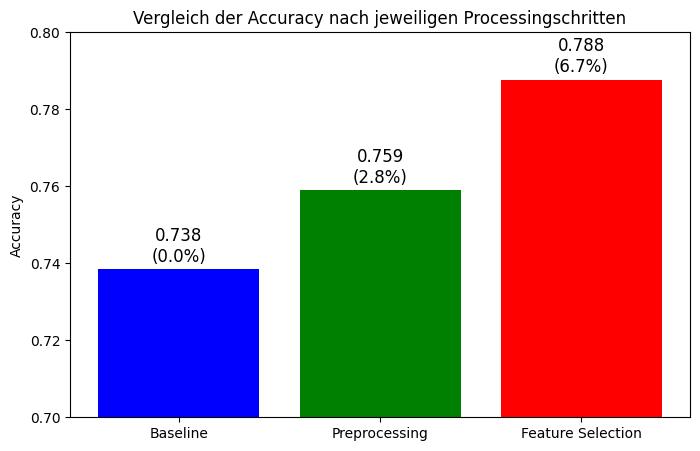

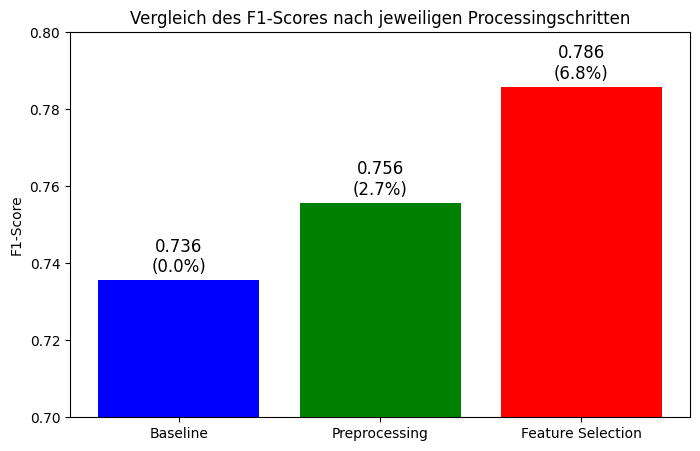

In [443]:
# DataFrame filtern
benchmark_df_filtered = benchmark_df[benchmark_df["Run"].isin(["LR Baseline", "LR Binning", "LR Feature Selektion"])]

labels = ["Baseline", "Preprocessing", "Feature Selection"]

# Berechnung der prozentualen Veränderung für Accuracy
baseline_acc = benchmark_df_filtered.iloc[0]["Accuracy"]
percentage_changes_acc = [(acc - baseline_acc) / baseline_acc * 100 for acc in benchmark_df_filtered["Accuracy"]]

# Berechnung der prozentualen Veränderung für F1-Score
baseline_f1 = benchmark_df_filtered.iloc[0]["F1-Score"]
percentage_changes_f1 = [(f1 - baseline_f1) / baseline_f1 * 100 for f1 in benchmark_df_filtered["F1-Score"]]

# Balkendiagramm für Accuracy
plt.figure(figsize=(8, 5))
plt.bar(benchmark_df_filtered["Run"], benchmark_df_filtered["Accuracy"], color=['blue', 'green', 'red'])
plt.xlabel("")
plt.ylabel("Accuracy")
plt.title("Vergleich der Accuracy nach jeweiligen Processingschritten")
plt.ylim(0.7, 0.8)

# Achsen-Beschriftungen anpassen
plt.xticks(ticks=range(len(labels)), labels=labels)

# Werte über den Balken anzeigen
for i, (acc, perc) in enumerate(zip(benchmark_df_filtered["Accuracy"], percentage_changes_acc)):
    plt.text(i, acc + 0.002, f"{acc:.3f}\n({perc:.1f}%)", ha='center', fontsize=12)

plt.show()

# Balkendiagramm für F1-Score
plt.figure(figsize=(8, 5))
plt.bar(benchmark_df_filtered["Run"], benchmark_df_filtered["F1-Score"], color=['blue', 'green', 'red'])
plt.xlabel("")
plt.ylabel("F1-Score")
plt.title("Vergleich des F1-Scores nach jeweiligen Processingschritten")
plt.ylim(0.7, 0.8)

# Achsen-Beschriftungen anpassen
plt.xticks(ticks=range(len(labels)), labels=labels)

# Werte über den Balken anzeigen
for i, (f1, perc) in enumerate(zip(benchmark_df_filtered["F1-Score"], percentage_changes_f1)):
    plt.text(i, f1 + 0.002, f"{f1:.3f}\n({perc:.1f}%)", ha='center', fontsize=12)

plt.show()

Das erzeugen von neuen Features durch Featureengineering, Standardisierung, Scaling, Normalisierung, Binning, Target encoding und odinal encoding hat das Modell um 2.8 % (Accuracy) bzw. 2.7 % (F1 Score) verbessert!
Eine vorläufige Featureselektion hat das Modell um weitere 3.9% (Accuracy) bzw. 4.1% (F1 Score) verbessert. Die Featureselektion kann im weiteren Projektverlauf weiter optimiert werden.

<h1> Daten abspeichern

In [95]:
df_test_no_missing_values.to_parquet("../data/processed/df_test_all_features.parquet", index=True)
df_training_no_missing_values.to_parquet("../data/processed/df_training_all_features.parquet", index=True)


Diese Dataframes enthalten nun alle Features. Im nächsten Schritt können diese Features genutzt werden um verschiedene Modelle zu testen. Dabei gibt es keine mir bekannten Einschränkungen für die Modellauswahl, da jedes Feature auf verschiedene Arten transformiert wurde und so jedes Modell die für sich geeigneten Features daraus auswählen kann.